# IMPORT LIBERIES AND DATASET FOR TRANSLANSTION MODEL

In [ ]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.3 MB/s 
     |████████████████████████████████| 1.2 MB 58.1 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 6.6 MB 46.1 MB/s 
     |████████████████████████████████| 596 kB 74.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from google.colab import drive
from IPython.display import display
from IPython.html import widgets

from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup

import torch
from torch import optim
from torch.nn import functional as F

# tqdm is a library in Python which is used for creating Progress Meters or Progress Bars
from tqdm import tqdm_notebook
import tqdm

sns.set()

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [ ]:

working_dir_path = '/content/drive/MyDrive/Colab Notebooks/'

model_path = working_dir_path + 'afrikdico/models/'

data = pd.read_csv( working_dir_path +'French_to_fongbe.csv')

In [ ]:
# for index, rows in dataset.iterrows():
  # print(rows)

data

,Fon,French
0,Ɖo gan tantɔn kpo cεju afɔton.,A 8 heures moins le quart
1,"Nu akwε enε ɔ, un nyi xixɔtɔ a.",A ce prix-là je ne suis pas acheteur
2,"Do hwe enε ɔ nu ɖo xwe ɔ mε ɔ, mi sɔ na ɖo hwe...","À cette époque de l'année, vous n'aurez pas be..."
3,"Hwe e nε ɔ nu ɔ, lεtliki ko ɖe a.","À cette époque-là, il n'y avait pas d'électricité"
4,"Ɖo tlolo mε ɔ, e mɔ wiimi bo zɔn jε mε.","A l'instant, elle en rencontra et s'y plongea ..."
...,...,...
53361,"Mi na mɔ, ye jlε.","Vous verrez, c'est indiqué."
53362,Mi d'ayihun ganji.,Vous vous êtes bien amusés ?
53363,Mi gble wu mi ɖe lε.,Vous vous êtes blessés .
53364,E ɖo xεsi ɖiɖi sin hu do à ?,Y a-t-il besoin d’avoir peur ?


## Dividing data into training and testing data

In [ ]:
train_dataset = data.sample(frac=0.8, random_state=25)

data_left = data.drop(train_dataset.index)

test_dataset = data_left.sample(frac=0.8, random_state=25)

eval_data = data_left.drop(test_dataset.index)


print(f"No. of training examples: {train_dataset.shape[0]}")
print(f"No. of testing examples: {test_dataset.shape[0]}")
print(f"No. of evaluition examples: {eval_data.shape[0]}")


# No. of training examples: 42693
# No. of testing examples: 10673

No. of training examples: 42693
No. of testing examples: 8538
No. of evaluition examples: 2135


In [ ]:
eval_data.to_csv(working_dir_path+'eval_data.csv')

# MODEL SECTION

In [ ]:
model_repo = 'google/mt5-small'
max_seq_len = 20
# model.config.max_length

In [ ]:
# Word tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_repo)

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [ ]:
# Model description: https://huggingface.co/google/mt5-small

# translation_model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)


In [ ]:
# putting the model on the GPU for better performance

# translation_model = translation_model.cuda()

## Testing the empty pretrained model

In [ ]:
# input_sent = 'Here is our test sentense'
# token_ids = tokenizer.encode(input_sent, return_tensors='pt').cuda()

# token_ids

# model_out = translation_model.generate(token_ids)
# model_out

# output_text = tokenizer.convert_tokens_to_string(
#     tokenizer.convert_ids_to_tokens(model_out[0])
# )

# print(output_text)

# STEPS OF WORKFLOW


1.   Load the pretrained model and tokenizer
2.   Load the dataset
3.   Transform the dataset into input
4.   Train and Finetune the model on our dataset
5.   Test the Model



In [ ]:
# tokenizer.vocab['fon']
# sorted(tokenizer.vocab.items(), key = lambda x: x[1])

In [ ]:
# Adding vocab tokens savely using the <> to avoid errors if they are already prensent in the tokenzer

# special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
# tokenizer.add_special_tokens(special_tokens_dict)
# translation_model.resize_token_embeddings(len(tokenizer))


In [ ]:
# lets see what we got in the config
# model.config
# translation_model.config.max_length

In [ ]:
# testing tokenizer
token_ids = tokenizer.encode(
    'example_input_str.', return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[11310,   290, 14435,   290,  8940,   260,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
['▁example', '_', 'input', '_', 'str', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
# langauge tranlation token mapping 
LANG_TOKEN_MAPPING = {
    'Fon': '<fo>',
    'French': '<fr>'
}

In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

# we should not here that the translation parameter represent a row in our dataset(having both langauges)

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []

  for index, rows in batch.iterrows():
    translation_set = rows
  # for translation_set in batch:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.sample(frac=1)
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)


# evaluation function 

def eval_model(model, 
               gdataset,
               batch_size,
               max_iters=8,
               tokenizer=tokenizer):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
# getting the first row in our dataset to test the format_translation_data function
translations = data.loc[0]
translations['French']

'A 8 heures moins le quart'

In [ ]:

# Testing `data_transform`
in_ids, out_ids = format_translation_data(data.loc[2], LANG_TOKEN_MAPPING, tokenizer)

# print('input_token_ids:\n\n' , in_ids)
# print('\n\ntarget_token_ids:\n\n' , out_ids)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
# data_gen = get_data_generator( dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
# data_batch = next(data_gen)
# print('Input shape:', data_batch[0].shape)
# print('Output shape:', data_batch[1].shape)

▁< fr > Do ▁hwe ▁en ε ▁ ɔ ▁nu ▁ ɖ o ▁xwe ▁ ɔ ▁m ε ▁ ɔ , ▁mi ▁ s ɔ ▁na ▁ ɖ o ▁hwe yiv ɔ ▁sin ▁at ink ε n ▁sin ▁hu ▁do ▁ a . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁À ▁ cette ▁ épo que ▁de ▁ l ' année , ▁ vous ▁ n ' a urez ▁pas ▁beso in ▁de ▁produit ▁sol aire </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

# TRAINING AND TESTING THE MODEL

In [ ]:
# # MODEL PARAMETERS

# n_epochs = 100
# batch_size = 16
# print_freq = 50
# checkpoint_freq = 1000
# lr = 5e-4 #learning rate btw 1e-3 and 1e-5
# n_batches = int(np.ceil(len(train_dataset) / batch_size))
# total_steps = n_epochs * n_batches
# n_warmup_steps = int(total_steps * 0.01)

In [ ]:
# # Optimizer
# optimizer = AdamW(model.parameters(), lr=lr)
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, n_warmup_steps, total_steps)

In [ ]:

def train_model(
    model,
    train_dataset,
    n_epochs = 13,
    batch_size = 16
    ):
  from operator import index
  # training varaibles
  losses = []
  validation_losses = []
  epochs = []

  # MODEL PARAMETERS
  
  print_freq = 50
  checkpoint_freq = 1000
  lr = 5e-4 #learning rate btw 1e-3 and 1e-5
  n_batches = int(np.ceil(len(train_dataset) / batch_size))
  total_steps = n_epochs * n_batches
  n_warmup_steps = int(total_steps * 0.01)

  # Optimizer
  optimizer = AdamW(model.parameters(), lr=lr)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, n_warmup_steps, total_steps)


  for epoch_idx in range(n_epochs):
    # Randomize data order
    data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                        tokenizer=tokenizer, batch_size=batch_size)
  
    for batch_idx, (input_batch, label_batch) \
        in tqdm_notebook(enumerate(data_generator), total=n_batches):

      optimizer.zero_grad()

      # Forward pass
      model_out = model.forward(
          input_ids = input_batch,
          labels = label_batch)

      # Calculate loss and update weights
      loss = model_out.loss
      losses.append(loss.item())
      loss.backward()  #update all the weights
      optimizer.step()
      scheduler.step()

      # Print training update info
      if (batch_idx + 1) % print_freq == 0:
        avg_loss = np.mean(losses[-print_freq:])
        print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
            epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
        
      if (batch_idx + 1) % checkpoint_freq == 0:
        test_loss = eval_model(model, test_dataset, batch_size= batch_size)

        # getting the validation loss and storing it
        # validation_losses.append(test_loss)

        print('Saving model with test loss of {:.3f}'.format(test_loss))

    epochs.append(epoch_idx)
    validation_losses.append(eval_model(model, test_dataset, batch_size= batch_size))

  # preparing return data
  validation_losses_epoch = pd.DataFrame()
  validation_losses_epoch['epochs'] = epochs
  validation_losses_epoch['validation_losses'] = validation_losses

  training_result = {
      'validation_losses_epoch' : validation_losses_epoch,
      'losses' : losses,
      'n_epochs' : n_epochs,
      'batch_size' : batch_size,
      'n_batches' : n_batches,
      'total_steps' : total_steps
  }

  # saving data and model data
  epoch_to_str = str(n_epochs)
  batch_size_to_str = str(batch_size)

  validation_losses_epoch.to_csv(
      model_path+'mt5_model_'+epoch_to_str+'_'+batch_size_to_str+'.csv',
      index =False)

  torch.save(
      model,
      model_path+'mt5_model_'+epoch_to_str+'_'+batch_size_to_str+'.pt')
  
  return training_result

In [ ]:
for n_epochs in range(22,23):
  # initializing model
  model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)

  # placing the model on the GPU
  model = model.cuda()

  # Adding vocab tokens savely using the <> to avoid errors if they are already prensent in the tokenzer
  special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
  tokenizer.add_special_tokens(special_tokens_dict)
  model.resize_token_embeddings(len(tokenizer))

  # training the model
  train_model(model, train_dataset,n_epochs=n_epochs ,batch_size= 16)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 38.883 | lr: 4.9309664694280084e-05
Epoch: 1 | Step: 100 | Avg. loss: 27.837 | lr: 9.861932938856017e-05
Epoch: 1 | Step: 150 | Avg. loss: 19.921 | lr: 0.00014792899408284024
Epoch: 1 | Step: 200 | Avg. loss: 11.329 | lr: 0.00019723865877712034
Epoch: 1 | Step: 250 | Avg. loss: 6.662 | lr: 0.0002465483234714004
Epoch: 1 | Step: 300 | Avg. loss: 4.785 | lr: 0.0002958579881656805
Epoch: 1 | Step: 350 | Avg. loss: 3.892 | lr: 0.00034516765285996055
Epoch: 1 | Step: 400 | Avg. loss: 3.355 | lr: 0.00039447731755424067
Epoch: 1 | Step: 450 | Avg. loss: 3.197 | lr: 0.0004437869822485207
Epoch: 1 | Step: 500 | Avg. loss: 2.912 | lr: 0.0004930966469428008
Epoch: 1 | Step: 550 | Avg. loss: 2.798 | lr: 0.0004995717472711338
Epoch: 1 | Step: 600 | Avg. loss: 2.549 | lr: 0.0004990737789817545
Epoch: 1 | Step: 650 | Avg. loss: 2.560 | lr: 0.0004985758106923751
Epoch: 1 | Step: 700 | Avg. loss: 2.406 | lr: 0.0004980778424029958
Epoch: 1 | Step: 750 | Avg. loss: 2.307 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 1.592 | lr: 0.00047796988287785835
Epoch: 2 | Step: 100 | Avg. loss: 1.609 | lr: 0.000477471914588479
Epoch: 2 | Step: 150 | Avg. loss: 1.593 | lr: 0.0004769739462990997
Epoch: 2 | Step: 200 | Avg. loss: 1.577 | lr: 0.0004764759780097204
Epoch: 2 | Step: 250 | Avg. loss: 1.613 | lr: 0.000475978009720341
Epoch: 2 | Step: 300 | Avg. loss: 1.609 | lr: 0.0004754800414309617
Epoch: 2 | Step: 350 | Avg. loss: 1.632 | lr: 0.00047498207314158235
Epoch: 2 | Step: 400 | Avg. loss: 1.606 | lr: 0.000474484104852203
Epoch: 2 | Step: 450 | Avg. loss: 1.554 | lr: 0.0004739861365628237
Epoch: 2 | Step: 500 | Avg. loss: 1.555 | lr: 0.0004734881682734444
Epoch: 2 | Step: 550 | Avg. loss: 1.548 | lr: 0.000472990199984065
Epoch: 2 | Step: 600 | Avg. loss: 1.572 | lr: 0.0004724922316946857
Epoch: 2 | Step: 650 | Avg. loss: 1.493 | lr: 0.0004719942634053064
Epoch: 2 | Step: 700 | Avg. loss: 1.538 | lr: 0.000471496295115927
Epoch: 2 | Step: 750 | Avg. loss: 1.514 | lr: 0.0004

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 1.322 | lr: 0.0004513883355907896
Epoch: 3 | Step: 100 | Avg. loss: 1.326 | lr: 0.0004508903673014103
Epoch: 3 | Step: 150 | Avg. loss: 1.292 | lr: 0.0004503923990120309
Epoch: 3 | Step: 200 | Avg. loss: 1.308 | lr: 0.00044989443072265156
Epoch: 3 | Step: 250 | Avg. loss: 1.312 | lr: 0.00044939646243327225
Epoch: 3 | Step: 300 | Avg. loss: 1.302 | lr: 0.00044889849414389294
Epoch: 3 | Step: 350 | Avg. loss: 1.323 | lr: 0.0004484005258545136
Epoch: 3 | Step: 400 | Avg. loss: 1.305 | lr: 0.0004479025575651343
Epoch: 3 | Step: 450 | Avg. loss: 1.301 | lr: 0.00044740458927575497
Epoch: 3 | Step: 500 | Avg. loss: 1.342 | lr: 0.00044690662098637556
Epoch: 3 | Step: 550 | Avg. loss: 1.271 | lr: 0.00044640865269699625
Epoch: 3 | Step: 600 | Avg. loss: 1.324 | lr: 0.00044591068440761694
Epoch: 3 | Step: 650 | Avg. loss: 1.319 | lr: 0.0004454127161182376
Epoch: 3 | Step: 700 | Avg. loss: 1.261 | lr: 0.0004449147478288583
Epoch: 3 | Step: 750 | Avg. loss: 1.292 | 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 1.100 | lr: 0.0004248067883037208
Epoch: 4 | Step: 100 | Avg. loss: 1.080 | lr: 0.0004243088200143415
Epoch: 4 | Step: 150 | Avg. loss: 1.103 | lr: 0.00042381085172496215
Epoch: 4 | Step: 200 | Avg. loss: 1.110 | lr: 0.00042331288343558284
Epoch: 4 | Step: 250 | Avg. loss: 1.082 | lr: 0.00042281491514620354
Epoch: 4 | Step: 300 | Avg. loss: 1.077 | lr: 0.0004223169468568241
Epoch: 4 | Step: 350 | Avg. loss: 1.098 | lr: 0.0004218189785674448
Epoch: 4 | Step: 400 | Avg. loss: 1.052 | lr: 0.0004213210102780655
Epoch: 4 | Step: 450 | Avg. loss: 1.112 | lr: 0.00042082304198868615
Epoch: 4 | Step: 500 | Avg. loss: 1.080 | lr: 0.00042032507369930684
Epoch: 4 | Step: 550 | Avg. loss: 1.121 | lr: 0.00041982710540992754
Epoch: 4 | Step: 600 | Avg. loss: 1.113 | lr: 0.0004193291371205482
Epoch: 4 | Step: 650 | Avg. loss: 1.069 | lr: 0.0004188311688311688
Epoch: 4 | Step: 700 | Avg. loss: 1.075 | lr: 0.0004183332005417895
Epoch: 4 | Step: 750 | Avg. loss: 1.061 | l

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 0.938 | lr: 0.0003982252410166521
Epoch: 5 | Step: 100 | Avg. loss: 0.906 | lr: 0.00039772727272727274
Epoch: 5 | Step: 150 | Avg. loss: 0.901 | lr: 0.0003972293044378934
Epoch: 5 | Step: 200 | Avg. loss: 0.903 | lr: 0.0003967313361485141
Epoch: 5 | Step: 250 | Avg. loss: 0.885 | lr: 0.0003962333678591347
Epoch: 5 | Step: 300 | Avg. loss: 0.860 | lr: 0.0003957353995697554
Epoch: 5 | Step: 350 | Avg. loss: 0.910 | lr: 0.0003952374312803761
Epoch: 5 | Step: 400 | Avg. loss: 0.893 | lr: 0.00039473946299099674
Epoch: 5 | Step: 450 | Avg. loss: 0.900 | lr: 0.00039424149470161743
Epoch: 5 | Step: 500 | Avg. loss: 0.913 | lr: 0.0003937435264122381
Epoch: 5 | Step: 550 | Avg. loss: 0.940 | lr: 0.0003932455581228587
Epoch: 5 | Step: 600 | Avg. loss: 0.930 | lr: 0.0003927475898334794
Epoch: 5 | Step: 650 | Avg. loss: 0.890 | lr: 0.0003922496215441001
Epoch: 5 | Step: 700 | Avg. loss: 0.887 | lr: 0.00039175165325472074
Epoch: 5 | Step: 750 | Avg. loss: 0.879 | lr:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg. loss: 0.752 | lr: 0.0003716436937295833
Epoch: 6 | Step: 100 | Avg. loss: 0.713 | lr: 0.00037114572544020397
Epoch: 6 | Step: 150 | Avg. loss: 0.738 | lr: 0.00037064775715082467
Epoch: 6 | Step: 200 | Avg. loss: 0.733 | lr: 0.0003701497888614453
Epoch: 6 | Step: 250 | Avg. loss: 0.756 | lr: 0.000369651820572066
Epoch: 6 | Step: 300 | Avg. loss: 0.729 | lr: 0.00036915385228268664
Epoch: 6 | Step: 350 | Avg. loss: 0.722 | lr: 0.0003686558839933073
Epoch: 6 | Step: 400 | Avg. loss: 0.714 | lr: 0.00036815791570392797
Epoch: 6 | Step: 450 | Avg. loss: 0.744 | lr: 0.00036765994741454867
Epoch: 6 | Step: 500 | Avg. loss: 0.732 | lr: 0.0003671619791251693
Epoch: 6 | Step: 550 | Avg. loss: 0.745 | lr: 0.00036666401083579
Epoch: 6 | Step: 600 | Avg. loss: 0.739 | lr: 0.0003661660425464107
Epoch: 6 | Step: 650 | Avg. loss: 0.738 | lr: 0.0003656680742570313
Epoch: 6 | Step: 700 | Avg. loss: 0.708 | lr: 0.000365170105967652
Epoch: 6 | Step: 750 | Avg. loss: 0.762 | lr: 0.

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg. loss: 0.588 | lr: 0.00034506214644251457
Epoch: 7 | Step: 100 | Avg. loss: 0.606 | lr: 0.00034456417815313526
Epoch: 7 | Step: 150 | Avg. loss: 0.619 | lr: 0.00034406620986375584
Epoch: 7 | Step: 200 | Avg. loss: 0.584 | lr: 0.00034356824157437654
Epoch: 7 | Step: 250 | Avg. loss: 0.580 | lr: 0.00034307027328499723
Epoch: 7 | Step: 300 | Avg. loss: 0.585 | lr: 0.00034257230499561787
Epoch: 7 | Step: 350 | Avg. loss: 0.582 | lr: 0.00034207433670623857
Epoch: 7 | Step: 400 | Avg. loss: 0.591 | lr: 0.00034157636841685926
Epoch: 7 | Step: 450 | Avg. loss: 0.573 | lr: 0.00034107840012747984
Epoch: 7 | Step: 500 | Avg. loss: 0.616 | lr: 0.00034058043183810054
Epoch: 7 | Step: 550 | Avg. loss: 0.548 | lr: 0.00034008246354872123
Epoch: 7 | Step: 600 | Avg. loss: 0.597 | lr: 0.00033958449525934187
Epoch: 7 | Step: 650 | Avg. loss: 0.573 | lr: 0.00033908652696996257
Epoch: 7 | Step: 700 | Avg. loss: 0.575 | lr: 0.00033858855868058326
Epoch: 7 | Step: 750 | Avg. loss: 0

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 8 | Step: 50 | Avg. loss: 0.540 | lr: 0.0003184805991554458
Epoch: 8 | Step: 100 | Avg. loss: 0.483 | lr: 0.00031798263086606644
Epoch: 8 | Step: 150 | Avg. loss: 0.515 | lr: 0.00031748466257668713
Epoch: 8 | Step: 200 | Avg. loss: 0.493 | lr: 0.0003169866942873078
Epoch: 8 | Step: 250 | Avg. loss: 0.453 | lr: 0.00031648872599792846
Epoch: 8 | Step: 300 | Avg. loss: 0.476 | lr: 0.0003159907577085491
Epoch: 8 | Step: 350 | Avg. loss: 0.511 | lr: 0.0003154927894191698
Epoch: 8 | Step: 400 | Avg. loss: 0.435 | lr: 0.00031499482112979044
Epoch: 8 | Step: 450 | Avg. loss: 0.489 | lr: 0.00031449685284041113
Epoch: 8 | Step: 500 | Avg. loss: 0.485 | lr: 0.0003139988845510318
Epoch: 8 | Step: 550 | Avg. loss: 0.469 | lr: 0.00031350091626165246
Epoch: 8 | Step: 600 | Avg. loss: 0.455 | lr: 0.00031300294797227316
Epoch: 8 | Step: 650 | Avg. loss: 0.485 | lr: 0.0003125049796828938
Epoch: 8 | Step: 700 | Avg. loss: 0.457 | lr: 0.00031200701139351444
Epoch: 8 | Step: 750 | Avg. loss: 0.467 |

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 9 | Step: 50 | Avg. loss: 0.375 | lr: 0.00029189905186837703
Epoch: 9 | Step: 100 | Avg. loss: 0.359 | lr: 0.00029140108357899767
Epoch: 9 | Step: 150 | Avg. loss: 0.389 | lr: 0.00029090311528961836
Epoch: 9 | Step: 200 | Avg. loss: 0.379 | lr: 0.000290405147000239
Epoch: 9 | Step: 250 | Avg. loss: 0.366 | lr: 0.0002899071787108597
Epoch: 9 | Step: 300 | Avg. loss: 0.368 | lr: 0.0002894092104214804
Epoch: 9 | Step: 350 | Avg. loss: 0.368 | lr: 0.00028891124213210103
Epoch: 9 | Step: 400 | Avg. loss: 0.368 | lr: 0.0002884132738427217
Epoch: 9 | Step: 450 | Avg. loss: 0.338 | lr: 0.00028791530555334236
Epoch: 9 | Step: 500 | Avg. loss: 0.370 | lr: 0.000287417337263963
Epoch: 9 | Step: 550 | Avg. loss: 0.371 | lr: 0.0002869193689745837
Epoch: 9 | Step: 600 | Avg. loss: 0.391 | lr: 0.0002864214006852044
Epoch: 9 | Step: 650 | Avg. loss: 0.383 | lr: 0.00028592343239582503
Epoch: 9 | Step: 700 | Avg. loss: 0.387 | lr: 0.0002854254641064457
Epoch: 9 | Step: 750 | Avg. loss: 0.378 | lr:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 10 | Step: 50 | Avg. loss: 0.277 | lr: 0.00026531750458130826
Epoch: 10 | Step: 100 | Avg. loss: 0.313 | lr: 0.00026481953629192896
Epoch: 10 | Step: 150 | Avg. loss: 0.274 | lr: 0.0002643215680025496
Epoch: 10 | Step: 200 | Avg. loss: 0.292 | lr: 0.0002638235997131703
Epoch: 10 | Step: 250 | Avg. loss: 0.303 | lr: 0.000263325631423791
Epoch: 10 | Step: 300 | Avg. loss: 0.288 | lr: 0.00026282766313441157
Epoch: 10 | Step: 350 | Avg. loss: 0.285 | lr: 0.00026232969484503226
Epoch: 10 | Step: 400 | Avg. loss: 0.306 | lr: 0.00026183172655565296
Epoch: 10 | Step: 450 | Avg. loss: 0.305 | lr: 0.0002613337582662736
Epoch: 10 | Step: 500 | Avg. loss: 0.288 | lr: 0.0002608357899768943
Epoch: 10 | Step: 550 | Avg. loss: 0.291 | lr: 0.000260337821687515
Epoch: 10 | Step: 600 | Avg. loss: 0.284 | lr: 0.00025983985339813557
Epoch: 10 | Step: 650 | Avg. loss: 0.298 | lr: 0.00025934188510875626
Epoch: 10 | Step: 700 | Avg. loss: 0.314 | lr: 0.00025884391681937696
Epoch: 10 | Step: 750 | Avg. 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 11 | Step: 50 | Avg. loss: 0.218 | lr: 0.0002387359572942395
Epoch: 11 | Step: 100 | Avg. loss: 0.242 | lr: 0.0002382379890048602
Epoch: 11 | Step: 150 | Avg. loss: 0.261 | lr: 0.00023774002071548086
Epoch: 11 | Step: 200 | Avg. loss: 0.224 | lr: 0.0002372420524261015
Epoch: 11 | Step: 250 | Avg. loss: 0.214 | lr: 0.0002367440841367222
Epoch: 11 | Step: 300 | Avg. loss: 0.228 | lr: 0.00023624611584734286
Epoch: 11 | Step: 350 | Avg. loss: 0.229 | lr: 0.0002357481475579635
Epoch: 11 | Step: 400 | Avg. loss: 0.243 | lr: 0.0002352501792685842
Epoch: 11 | Step: 450 | Avg. loss: 0.240 | lr: 0.00023475221097920486
Epoch: 11 | Step: 500 | Avg. loss: 0.244 | lr: 0.00023425424268982552
Epoch: 11 | Step: 550 | Avg. loss: 0.255 | lr: 0.0002337562744004462
Epoch: 11 | Step: 600 | Avg. loss: 0.238 | lr: 0.00023325830611106686
Epoch: 11 | Step: 650 | Avg. loss: 0.238 | lr: 0.00023276033782168752
Epoch: 11 | Step: 700 | Avg. loss: 0.236 | lr: 0.0002322623695323082
Epoch: 11 | Step: 750 | Avg. 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 12 | Step: 50 | Avg. loss: 0.182 | lr: 0.00021215441000717075
Epoch: 12 | Step: 100 | Avg. loss: 0.189 | lr: 0.00021165644171779142
Epoch: 12 | Step: 150 | Avg. loss: 0.184 | lr: 0.00021115847342841206
Epoch: 12 | Step: 200 | Avg. loss: 0.181 | lr: 0.00021066050513903275
Epoch: 12 | Step: 250 | Avg. loss: 0.185 | lr: 0.00021016253684965342
Epoch: 12 | Step: 300 | Avg. loss: 0.204 | lr: 0.0002096645685602741
Epoch: 12 | Step: 350 | Avg. loss: 0.183 | lr: 0.00020916660027089475
Epoch: 12 | Step: 400 | Avg. loss: 0.189 | lr: 0.00020866863198151542
Epoch: 12 | Step: 450 | Avg. loss: 0.177 | lr: 0.0002081706636921361
Epoch: 12 | Step: 500 | Avg. loss: 0.195 | lr: 0.00020767269540275675
Epoch: 12 | Step: 550 | Avg. loss: 0.166 | lr: 0.00020717472711337742
Epoch: 12 | Step: 600 | Avg. loss: 0.187 | lr: 0.0002066767588239981
Epoch: 12 | Step: 650 | Avg. loss: 0.178 | lr: 0.00020617879053461878
Epoch: 12 | Step: 700 | Avg. loss: 0.209 | lr: 0.00020568082224523942
Epoch: 12 | Step: 750 | 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 13 | Step: 50 | Avg. loss: 0.147 | lr: 0.00018557286272010199
Epoch: 13 | Step: 100 | Avg. loss: 0.159 | lr: 0.00018507489443072265
Epoch: 13 | Step: 150 | Avg. loss: 0.146 | lr: 0.00018457692614134332
Epoch: 13 | Step: 200 | Avg. loss: 0.132 | lr: 0.00018407895785196399
Epoch: 13 | Step: 250 | Avg. loss: 0.163 | lr: 0.00018358098956258465
Epoch: 13 | Step: 300 | Avg. loss: 0.141 | lr: 0.00018308302127320535
Epoch: 13 | Step: 350 | Avg. loss: 0.152 | lr: 0.000182585052983826
Epoch: 13 | Step: 400 | Avg. loss: 0.146 | lr: 0.00018208708469444665
Epoch: 13 | Step: 450 | Avg. loss: 0.139 | lr: 0.00018158911640506735
Epoch: 13 | Step: 500 | Avg. loss: 0.171 | lr: 0.000181091148115688
Epoch: 13 | Step: 550 | Avg. loss: 0.143 | lr: 0.00018059317982630865
Epoch: 13 | Step: 600 | Avg. loss: 0.150 | lr: 0.00018009521153692935
Epoch: 13 | Step: 650 | Avg. loss: 0.150 | lr: 0.00017959724324755001
Epoch: 13 | Step: 700 | Avg. loss: 0.157 | lr: 0.00017909927495817065
Epoch: 13 | Step: 750 | A

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 14 | Step: 50 | Avg. loss: 0.105 | lr: 0.00015899131543303322
Epoch: 14 | Step: 100 | Avg. loss: 0.108 | lr: 0.0001584933471436539
Epoch: 14 | Step: 150 | Avg. loss: 0.115 | lr: 0.00015799537885427455
Epoch: 14 | Step: 200 | Avg. loss: 0.104 | lr: 0.00015749741056489522
Epoch: 14 | Step: 250 | Avg. loss: 0.111 | lr: 0.0001569994422755159
Epoch: 14 | Step: 300 | Avg. loss: 0.116 | lr: 0.00015650147398613658
Epoch: 14 | Step: 350 | Avg. loss: 0.118 | lr: 0.00015600350569675722
Epoch: 14 | Step: 400 | Avg. loss: 0.113 | lr: 0.0001555055374073779
Epoch: 14 | Step: 450 | Avg. loss: 0.121 | lr: 0.00015500756911799858
Epoch: 14 | Step: 500 | Avg. loss: 0.119 | lr: 0.00015450960082861922
Epoch: 14 | Step: 550 | Avg. loss: 0.112 | lr: 0.0001540116325392399
Epoch: 14 | Step: 600 | Avg. loss: 0.119 | lr: 0.00015351366424986058
Epoch: 14 | Step: 650 | Avg. loss: 0.120 | lr: 0.00015301569596048125
Epoch: 14 | Step: 700 | Avg. loss: 0.121 | lr: 0.0001525177276711019
Epoch: 14 | Step: 750 | Av

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 15 | Step: 50 | Avg. loss: 0.099 | lr: 0.00013240976814596448
Epoch: 15 | Step: 100 | Avg. loss: 0.104 | lr: 0.00013191179985658514
Epoch: 15 | Step: 150 | Avg. loss: 0.101 | lr: 0.00013141383156720578
Epoch: 15 | Step: 200 | Avg. loss: 0.090 | lr: 0.00013091586327782648
Epoch: 15 | Step: 250 | Avg. loss: 0.089 | lr: 0.00013041789498844714
Epoch: 15 | Step: 300 | Avg. loss: 0.087 | lr: 0.00012991992669906778
Epoch: 15 | Step: 350 | Avg. loss: 0.094 | lr: 0.00012942195840968848
Epoch: 15 | Step: 400 | Avg. loss: 0.082 | lr: 0.00012892399012030914
Epoch: 15 | Step: 450 | Avg. loss: 0.081 | lr: 0.0001284260218309298
Epoch: 15 | Step: 500 | Avg. loss: 0.084 | lr: 0.00012792805354155048
Epoch: 15 | Step: 550 | Avg. loss: 0.105 | lr: 0.00012743008525217114
Epoch: 15 | Step: 600 | Avg. loss: 0.093 | lr: 0.0001269321169627918
Epoch: 15 | Step: 650 | Avg. loss: 0.090 | lr: 0.00012643414867341248
Epoch: 15 | Step: 700 | Avg. loss: 0.098 | lr: 0.00012593618038403314
Epoch: 15 | Step: 750 |

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 16 | Step: 50 | Avg. loss: 0.070 | lr: 0.00010582822085889571
Epoch: 16 | Step: 100 | Avg. loss: 0.069 | lr: 0.00010533025256951638
Epoch: 16 | Step: 150 | Avg. loss: 0.071 | lr: 0.00010483228428013704
Epoch: 16 | Step: 200 | Avg. loss: 0.070 | lr: 0.00010433431599075771
Epoch: 16 | Step: 250 | Avg. loss: 0.076 | lr: 0.00010383634770137838
Epoch: 16 | Step: 300 | Avg. loss: 0.070 | lr: 0.00010333837941199904
Epoch: 16 | Step: 350 | Avg. loss: 0.070 | lr: 0.00010284041112261971
Epoch: 16 | Step: 400 | Avg. loss: 0.068 | lr: 0.00010234244283324039
Epoch: 16 | Step: 450 | Avg. loss: 0.076 | lr: 0.00010184447454386104
Epoch: 16 | Step: 500 | Avg. loss: 0.077 | lr: 0.00010134650625448172
Epoch: 16 | Step: 550 | Avg. loss: 0.065 | lr: 0.00010084853796510239
Epoch: 16 | Step: 600 | Avg. loss: 0.063 | lr: 0.00010035056967572304
Epoch: 16 | Step: 650 | Avg. loss: 0.065 | lr: 9.985260138634372e-05
Epoch: 16 | Step: 700 | Avg. loss: 0.073 | lr: 9.935463309696438e-05
Epoch: 16 | Step: 750 |

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 17 | Step: 50 | Avg. loss: 0.055 | lr: 7.924667357182696e-05
Epoch: 17 | Step: 100 | Avg. loss: 0.052 | lr: 7.874870528244761e-05
Epoch: 17 | Step: 150 | Avg. loss: 0.050 | lr: 7.825073699306829e-05
Epoch: 17 | Step: 200 | Avg. loss: 0.056 | lr: 7.775276870368896e-05
Epoch: 17 | Step: 250 | Avg. loss: 0.058 | lr: 7.725480041430961e-05
Epoch: 17 | Step: 300 | Avg. loss: 0.056 | lr: 7.675683212493029e-05
Epoch: 17 | Step: 350 | Avg. loss: 0.041 | lr: 7.625886383555096e-05
Epoch: 17 | Step: 400 | Avg. loss: 0.055 | lr: 7.576089554617162e-05
Epoch: 17 | Step: 450 | Avg. loss: 0.052 | lr: 7.526292725679229e-05
Epoch: 17 | Step: 500 | Avg. loss: 0.064 | lr: 7.476495896741297e-05
Epoch: 17 | Step: 550 | Avg. loss: 0.058 | lr: 7.426699067803362e-05
Epoch: 17 | Step: 600 | Avg. loss: 0.060 | lr: 7.376902238865429e-05
Epoch: 17 | Step: 650 | Avg. loss: 0.059 | lr: 7.327105409927496e-05
Epoch: 17 | Step: 700 | Avg. loss: 0.057 | lr: 7.277308580989562e-05
Epoch: 17 | Step: 750 | Avg. loss: 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 18 | Step: 50 | Avg. loss: 0.040 | lr: 5.266512628475819e-05
Epoch: 18 | Step: 100 | Avg. loss: 0.039 | lr: 5.2167157995378855e-05
Epoch: 18 | Step: 150 | Avg. loss: 0.043 | lr: 5.166918970599952e-05
Epoch: 18 | Step: 200 | Avg. loss: 0.045 | lr: 5.1171221416620195e-05
Epoch: 18 | Step: 250 | Avg. loss: 0.036 | lr: 5.067325312724086e-05
Epoch: 18 | Step: 300 | Avg. loss: 0.045 | lr: 5.017528483786152e-05
Epoch: 18 | Step: 350 | Avg. loss: 0.047 | lr: 4.967731654848219e-05
Epoch: 18 | Step: 400 | Avg. loss: 0.045 | lr: 4.917934825910286e-05
Epoch: 18 | Step: 450 | Avg. loss: 0.040 | lr: 4.868137996972353e-05
Epoch: 18 | Step: 500 | Avg. loss: 0.044 | lr: 4.8183411680344195e-05
Epoch: 18 | Step: 550 | Avg. loss: 0.039 | lr: 4.768544339096487e-05
Epoch: 18 | Step: 600 | Avg. loss: 0.036 | lr: 4.7187475101585536e-05
Epoch: 18 | Step: 650 | Avg. loss: 0.041 | lr: 4.6689506812206195e-05
Epoch: 18 | Step: 700 | Avg. loss: 0.035 | lr: 4.619153852282687e-05
Epoch: 18 | Step: 750 | Avg. l

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 19 | Step: 50 | Avg. loss: 0.029 | lr: 2.6083578997689428e-05
Epoch: 19 | Step: 100 | Avg. loss: 0.030 | lr: 2.5585610708310098e-05
Epoch: 19 | Step: 150 | Avg. loss: 0.027 | lr: 2.508764241893076e-05
Epoch: 19 | Step: 200 | Avg. loss: 0.030 | lr: 2.458967412955143e-05
Epoch: 19 | Step: 250 | Avg. loss: 0.030 | lr: 2.4091705840172098e-05
Epoch: 19 | Step: 300 | Avg. loss: 0.029 | lr: 2.3593737550792768e-05
Epoch: 19 | Step: 350 | Avg. loss: 0.034 | lr: 2.3095769261413434e-05
Epoch: 19 | Step: 400 | Avg. loss: 0.025 | lr: 2.25978009720341e-05
Epoch: 19 | Step: 450 | Avg. loss: 0.027 | lr: 2.209983268265477e-05
Epoch: 19 | Step: 500 | Avg. loss: 0.031 | lr: 2.1601864393275434e-05
Epoch: 19 | Step: 550 | Avg. loss: 0.030 | lr: 2.1103896103896105e-05
Epoch: 19 | Step: 600 | Avg. loss: 0.029 | lr: 2.0605927814516775e-05
Epoch: 19 | Step: 650 | Avg. loss: 0.029 | lr: 2.0107959525137438e-05
Epoch: 19 | Step: 700 | Avg. loss: 0.028 | lr: 1.9609991235758108e-05
Epoch: 19 | Step: 750 | Av

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 38.133 | lr: 4.6904315196998124e-05
Epoch: 1 | Step: 100 | Avg. loss: 26.947 | lr: 9.380863039399625e-05
Epoch: 1 | Step: 150 | Avg. loss: 18.709 | lr: 0.00014071294559099437
Epoch: 1 | Step: 200 | Avg. loss: 11.137 | lr: 0.0001876172607879925
Epoch: 1 | Step: 250 | Avg. loss: 7.939 | lr: 0.00023452157598499062
Epoch: 1 | Step: 300 | Avg. loss: 5.643 | lr: 0.00028142589118198874
Epoch: 1 | Step: 350 | Avg. loss: 4.178 | lr: 0.00032833020637898687
Epoch: 1 | Step: 400 | Avg. loss: 3.579 | lr: 0.000375234521575985
Epoch: 1 | Step: 450 | Avg. loss: 3.349 | lr: 0.00042213883677298317
Epoch: 1 | Step: 500 | Avg. loss: 3.027 | lr: 0.00046904315196998124
Epoch: 1 | Step: 550 | Avg. loss: 2.812 | lr: 0.0004998391583249759
Epoch: 1 | Step: 600 | Avg. loss: 2.686 | lr: 0.000499366094574905
Epoch: 1 | Step: 650 | Avg. loss: 2.496 | lr: 0.0004988930308248339
Epoch: 1 | Step: 700 | Avg. loss: 2.424 | lr: 0.000498419967074763
Epoch: 1 | Step: 750 | Avg. loss: 2.357 |

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 1.645 | lr: 0.0004793176528468977
Epoch: 2 | Step: 100 | Avg. loss: 1.601 | lr: 0.0004788445890968267
Epoch: 2 | Step: 150 | Avg. loss: 1.599 | lr: 0.00047837152534675574
Epoch: 2 | Step: 200 | Avg. loss: 1.558 | lr: 0.00047789846159668474
Epoch: 2 | Step: 250 | Avg. loss: 1.570 | lr: 0.0004774253978466138
Epoch: 2 | Step: 300 | Avg. loss: 1.589 | lr: 0.00047695233409654285
Epoch: 2 | Step: 350 | Avg. loss: 1.604 | lr: 0.0004764792703464719
Epoch: 2 | Step: 400 | Avg. loss: 1.543 | lr: 0.0004760062065964009
Epoch: 2 | Step: 450 | Avg. loss: 1.575 | lr: 0.00047553314284632997
Epoch: 2 | Step: 500 | Avg. loss: 1.564 | lr: 0.000475060079096259
Epoch: 2 | Step: 550 | Avg. loss: 1.546 | lr: 0.0004745870153461881
Epoch: 2 | Step: 600 | Avg. loss: 1.595 | lr: 0.0004741139515961171
Epoch: 2 | Step: 650 | Avg. loss: 1.553 | lr: 0.00047364088784604614
Epoch: 2 | Step: 700 | Avg. loss: 1.507 | lr: 0.0004731678240959752
Epoch: 2 | Step: 750 | Avg. loss: 1.588 | lr:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 1.272 | lr: 0.00045406550986810983
Epoch: 3 | Step: 100 | Avg. loss: 1.287 | lr: 0.0004535924461180389
Epoch: 3 | Step: 150 | Avg. loss: 1.368 | lr: 0.0004531193823679679
Epoch: 3 | Step: 200 | Avg. loss: 1.284 | lr: 0.00045264631861789695
Epoch: 3 | Step: 250 | Avg. loss: 1.323 | lr: 0.000452173254867826
Epoch: 3 | Step: 300 | Avg. loss: 1.276 | lr: 0.000451700191117755
Epoch: 3 | Step: 350 | Avg. loss: 1.334 | lr: 0.00045122712736768406
Epoch: 3 | Step: 400 | Avg. loss: 1.331 | lr: 0.0004507540636176131
Epoch: 3 | Step: 450 | Avg. loss: 1.268 | lr: 0.0004502809998675422
Epoch: 3 | Step: 500 | Avg. loss: 1.299 | lr: 0.0004498079361174712
Epoch: 3 | Step: 550 | Avg. loss: 1.320 | lr: 0.00044933487236740023
Epoch: 3 | Step: 600 | Avg. loss: 1.311 | lr: 0.0004488618086173293
Epoch: 3 | Step: 650 | Avg. loss: 1.265 | lr: 0.00044838874486725834
Epoch: 3 | Step: 700 | Avg. loss: 1.282 | lr: 0.00044791568111718735
Epoch: 3 | Step: 750 | Avg. loss: 1.256 | lr:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 1.104 | lr: 0.000428813366889322
Epoch: 4 | Step: 100 | Avg. loss: 1.130 | lr: 0.00042834030313925104
Epoch: 4 | Step: 150 | Avg. loss: 1.090 | lr: 0.0004278672393891801
Epoch: 4 | Step: 200 | Avg. loss: 1.105 | lr: 0.00042739417563910915
Epoch: 4 | Step: 250 | Avg. loss: 1.079 | lr: 0.00042692111188903816
Epoch: 4 | Step: 300 | Avg. loss: 1.094 | lr: 0.0004264480481389672
Epoch: 4 | Step: 350 | Avg. loss: 1.103 | lr: 0.00042597498438889627
Epoch: 4 | Step: 400 | Avg. loss: 1.116 | lr: 0.0004255019206388253
Epoch: 4 | Step: 450 | Avg. loss: 1.100 | lr: 0.0004250288568887543
Epoch: 4 | Step: 500 | Avg. loss: 1.060 | lr: 0.0004245557931386834
Epoch: 4 | Step: 550 | Avg. loss: 1.089 | lr: 0.00042408272938861244
Epoch: 4 | Step: 600 | Avg. loss: 1.097 | lr: 0.0004236096656385415
Epoch: 4 | Step: 650 | Avg. loss: 1.043 | lr: 0.0004231366018884705
Epoch: 4 | Step: 700 | Avg. loss: 1.065 | lr: 0.00042266353813839955
Epoch: 4 | Step: 750 | Avg. loss: 1.105 | lr

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 0.914 | lr: 0.0004035612239105342
Epoch: 5 | Step: 100 | Avg. loss: 0.878 | lr: 0.00040308816016046325
Epoch: 5 | Step: 150 | Avg. loss: 0.917 | lr: 0.0004026150964103923
Epoch: 5 | Step: 200 | Avg. loss: 0.896 | lr: 0.0004021420326603213
Epoch: 5 | Step: 250 | Avg. loss: 0.886 | lr: 0.00040166896891025036
Epoch: 5 | Step: 300 | Avg. loss: 0.911 | lr: 0.0004011959051601794
Epoch: 5 | Step: 350 | Avg. loss: 0.917 | lr: 0.0004007228414101085
Epoch: 5 | Step: 400 | Avg. loss: 0.913 | lr: 0.0004002497776600375
Epoch: 5 | Step: 450 | Avg. loss: 0.889 | lr: 0.0003997767139099665
Epoch: 5 | Step: 500 | Avg. loss: 0.881 | lr: 0.00039930365015989553
Epoch: 5 | Step: 550 | Avg. loss: 0.893 | lr: 0.0003988305864098246
Epoch: 5 | Step: 600 | Avg. loss: 0.934 | lr: 0.0003983575226597536
Epoch: 5 | Step: 650 | Avg. loss: 0.890 | lr: 0.00039788445890968265
Epoch: 5 | Step: 700 | Avg. loss: 0.902 | lr: 0.0003974113951596117
Epoch: 5 | Step: 750 | Avg. loss: 0.906 | lr:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg. loss: 0.744 | lr: 0.0003783090809317464
Epoch: 6 | Step: 100 | Avg. loss: 0.721 | lr: 0.00037783601718167545
Epoch: 6 | Step: 150 | Avg. loss: 0.739 | lr: 0.0003773629534316044
Epoch: 6 | Step: 200 | Avg. loss: 0.723 | lr: 0.00037688988968153346
Epoch: 6 | Step: 250 | Avg. loss: 0.730 | lr: 0.0003764168259314625
Epoch: 6 | Step: 300 | Avg. loss: 0.712 | lr: 0.00037594376218139157
Epoch: 6 | Step: 350 | Avg. loss: 0.691 | lr: 0.00037547069843132057
Epoch: 6 | Step: 400 | Avg. loss: 0.754 | lr: 0.00037499763468124963
Epoch: 6 | Step: 450 | Avg. loss: 0.675 | lr: 0.0003745245709311787
Epoch: 6 | Step: 500 | Avg. loss: 0.716 | lr: 0.00037405150718110774
Epoch: 6 | Step: 550 | Avg. loss: 0.726 | lr: 0.00037357844343103674
Epoch: 6 | Step: 600 | Avg. loss: 0.717 | lr: 0.0003731053796809658
Epoch: 6 | Step: 650 | Avg. loss: 0.711 | lr: 0.00037263231593089485
Epoch: 6 | Step: 700 | Avg. loss: 0.736 | lr: 0.0003721592521808239
Epoch: 6 | Step: 750 | Avg. loss: 0.687 |

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg. loss: 0.611 | lr: 0.00035305693795295855
Epoch: 7 | Step: 100 | Avg. loss: 0.565 | lr: 0.00035258387420288755
Epoch: 7 | Step: 150 | Avg. loss: 0.562 | lr: 0.0003521108104528166
Epoch: 7 | Step: 200 | Avg. loss: 0.563 | lr: 0.00035163774670274566
Epoch: 7 | Step: 250 | Avg. loss: 0.560 | lr: 0.0003511646829526747
Epoch: 7 | Step: 300 | Avg. loss: 0.579 | lr: 0.0003506916192026037
Epoch: 7 | Step: 350 | Avg. loss: 0.566 | lr: 0.0003502185554525328
Epoch: 7 | Step: 400 | Avg. loss: 0.595 | lr: 0.00034974549170246183
Epoch: 7 | Step: 450 | Avg. loss: 0.568 | lr: 0.0003492724279523909
Epoch: 7 | Step: 500 | Avg. loss: 0.547 | lr: 0.0003487993642023199
Epoch: 7 | Step: 550 | Avg. loss: 0.578 | lr: 0.00034832630045224895
Epoch: 7 | Step: 600 | Avg. loss: 0.528 | lr: 0.000347853236702178
Epoch: 7 | Step: 650 | Avg. loss: 0.570 | lr: 0.00034738017295210706
Epoch: 7 | Step: 700 | Avg. loss: 0.626 | lr: 0.00034690710920203606
Epoch: 7 | Step: 750 | Avg. loss: 0.588 | l

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 8 | Step: 50 | Avg. loss: 0.446 | lr: 0.0003278047949741707
Epoch: 8 | Step: 100 | Avg. loss: 0.451 | lr: 0.00032733173122409976
Epoch: 8 | Step: 150 | Avg. loss: 0.425 | lr: 0.0003268586674740288
Epoch: 8 | Step: 200 | Avg. loss: 0.453 | lr: 0.00032638560372395787
Epoch: 8 | Step: 250 | Avg. loss: 0.428 | lr: 0.00032591253997388687
Epoch: 8 | Step: 300 | Avg. loss: 0.461 | lr: 0.00032543947622381593
Epoch: 8 | Step: 350 | Avg. loss: 0.453 | lr: 0.000324966412473745
Epoch: 8 | Step: 400 | Avg. loss: 0.439 | lr: 0.00032449334872367404
Epoch: 8 | Step: 450 | Avg. loss: 0.462 | lr: 0.00032402028497360304
Epoch: 8 | Step: 500 | Avg. loss: 0.432 | lr: 0.0003235472212235321
Epoch: 8 | Step: 550 | Avg. loss: 0.494 | lr: 0.00032307415747346115
Epoch: 8 | Step: 600 | Avg. loss: 0.451 | lr: 0.0003226010937233902
Epoch: 8 | Step: 650 | Avg. loss: 0.459 | lr: 0.0003221280299733192
Epoch: 8 | Step: 700 | Avg. loss: 0.437 | lr: 0.00032165496622324827
Epoch: 8 | Step: 750 | Avg. loss: 0.492 | 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 9 | Step: 50 | Avg. loss: 0.367 | lr: 0.0003025526519953829
Epoch: 9 | Step: 100 | Avg. loss: 0.377 | lr: 0.00030207958824531196
Epoch: 9 | Step: 150 | Avg. loss: 0.357 | lr: 0.000301606524495241
Epoch: 9 | Step: 200 | Avg. loss: 0.349 | lr: 0.00030113346074517
Epoch: 9 | Step: 250 | Avg. loss: 0.384 | lr: 0.0003006603969950991
Epoch: 9 | Step: 300 | Avg. loss: 0.332 | lr: 0.00030018733324502813
Epoch: 9 | Step: 350 | Avg. loss: 0.365 | lr: 0.0002997142694949572
Epoch: 9 | Step: 400 | Avg. loss: 0.338 | lr: 0.0002992412057448862
Epoch: 9 | Step: 450 | Avg. loss: 0.371 | lr: 0.00029876814199481525
Epoch: 9 | Step: 500 | Avg. loss: 0.378 | lr: 0.0002982950782447443
Epoch: 9 | Step: 550 | Avg. loss: 0.376 | lr: 0.0002978220144946733
Epoch: 9 | Step: 600 | Avg. loss: 0.333 | lr: 0.0002973489507446023
Epoch: 9 | Step: 650 | Avg. loss: 0.368 | lr: 0.00029687588699453136
Epoch: 9 | Step: 700 | Avg. loss: 0.372 | lr: 0.0002964028232444604
Epoch: 9 | Step: 750 | Avg. loss: 0.363 | lr: 0.

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 10 | Step: 50 | Avg. loss: 0.244 | lr: 0.0002773005090165951
Epoch: 10 | Step: 100 | Avg. loss: 0.247 | lr: 0.00027682744526652417
Epoch: 10 | Step: 150 | Avg. loss: 0.269 | lr: 0.00027635438151645317
Epoch: 10 | Step: 200 | Avg. loss: 0.293 | lr: 0.0002758813177663822
Epoch: 10 | Step: 250 | Avg. loss: 0.277 | lr: 0.00027540825401631123
Epoch: 10 | Step: 300 | Avg. loss: 0.282 | lr: 0.0002749351902662403
Epoch: 10 | Step: 350 | Avg. loss: 0.271 | lr: 0.0002744621265161693
Epoch: 10 | Step: 400 | Avg. loss: 0.291 | lr: 0.00027398906276609834
Epoch: 10 | Step: 450 | Avg. loss: 0.284 | lr: 0.0002735159990160274
Epoch: 10 | Step: 500 | Avg. loss: 0.307 | lr: 0.00027304293526595646
Epoch: 10 | Step: 550 | Avg. loss: 0.299 | lr: 0.00027256987151588546
Epoch: 10 | Step: 600 | Avg. loss: 0.280 | lr: 0.0002720968077658145
Epoch: 10 | Step: 650 | Avg. loss: 0.312 | lr: 0.00027162374401574357
Epoch: 10 | Step: 700 | Avg. loss: 0.296 | lr: 0.0002711506802656726
Epoch: 10 | Step: 750 | Avg.

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 11 | Step: 50 | Avg. loss: 0.232 | lr: 0.00025204836603780727
Epoch: 11 | Step: 100 | Avg. loss: 0.227 | lr: 0.00025157530228773627
Epoch: 11 | Step: 150 | Avg. loss: 0.229 | lr: 0.0002511022385376653
Epoch: 11 | Step: 200 | Avg. loss: 0.238 | lr: 0.0002506291747875944
Epoch: 11 | Step: 250 | Avg. loss: 0.223 | lr: 0.00025015611103752344
Epoch: 11 | Step: 300 | Avg. loss: 0.222 | lr: 0.0002496830472874525
Epoch: 11 | Step: 350 | Avg. loss: 0.228 | lr: 0.0002492099835373815
Epoch: 11 | Step: 400 | Avg. loss: 0.232 | lr: 0.00024873691978731055
Epoch: 11 | Step: 450 | Avg. loss: 0.194 | lr: 0.0002482638560372396
Epoch: 11 | Step: 500 | Avg. loss: 0.239 | lr: 0.00024779079228716866
Epoch: 11 | Step: 550 | Avg. loss: 0.226 | lr: 0.00024731772853709766
Epoch: 11 | Step: 600 | Avg. loss: 0.224 | lr: 0.0002468446647870267
Epoch: 11 | Step: 650 | Avg. loss: 0.217 | lr: 0.0002463716010369557
Epoch: 11 | Step: 700 | Avg. loss: 0.234 | lr: 0.0002458985372868848
Epoch: 11 | Step: 750 | Avg. 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 12 | Step: 50 | Avg. loss: 0.181 | lr: 0.00022679622305901944
Epoch: 12 | Step: 100 | Avg. loss: 0.186 | lr: 0.00022632315930894847
Epoch: 12 | Step: 150 | Avg. loss: 0.185 | lr: 0.0002258500955588775
Epoch: 12 | Step: 200 | Avg. loss: 0.177 | lr: 0.00022537703180880656
Epoch: 12 | Step: 250 | Avg. loss: 0.186 | lr: 0.0002249039680587356
Epoch: 12 | Step: 300 | Avg. loss: 0.172 | lr: 0.00022443090430866464
Epoch: 12 | Step: 350 | Avg. loss: 0.196 | lr: 0.00022395784055859367
Epoch: 12 | Step: 400 | Avg. loss: 0.181 | lr: 0.00022348477680852273
Epoch: 12 | Step: 450 | Avg. loss: 0.179 | lr: 0.00022301171305845176
Epoch: 12 | Step: 500 | Avg. loss: 0.180 | lr: 0.00022253864930838081
Epoch: 12 | Step: 550 | Avg. loss: 0.201 | lr: 0.00022206558555830982
Epoch: 12 | Step: 600 | Avg. loss: 0.187 | lr: 0.00022159252180823887
Epoch: 12 | Step: 650 | Avg. loss: 0.181 | lr: 0.0002211194580581679
Epoch: 12 | Step: 700 | Avg. loss: 0.184 | lr: 0.00022064639430809696
Epoch: 12 | Step: 750 | 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 13 | Step: 50 | Avg. loss: 0.139 | lr: 0.00020154408008023162
Epoch: 13 | Step: 100 | Avg. loss: 0.137 | lr: 0.00020107101633016065
Epoch: 13 | Step: 150 | Avg. loss: 0.153 | lr: 0.0002005979525800897
Epoch: 13 | Step: 200 | Avg. loss: 0.135 | lr: 0.00020012488883001874
Epoch: 13 | Step: 250 | Avg. loss: 0.157 | lr: 0.00019965182507994777
Epoch: 13 | Step: 300 | Avg. loss: 0.135 | lr: 0.0001991787613298768
Epoch: 13 | Step: 350 | Avg. loss: 0.150 | lr: 0.00019870569757980585
Epoch: 13 | Step: 400 | Avg. loss: 0.159 | lr: 0.00019823263382973488
Epoch: 13 | Step: 450 | Avg. loss: 0.144 | lr: 0.00019775957007966394
Epoch: 13 | Step: 500 | Avg. loss: 0.149 | lr: 0.00019728650632959297
Epoch: 13 | Step: 550 | Avg. loss: 0.145 | lr: 0.00019681344257952202
Epoch: 13 | Step: 600 | Avg. loss: 0.136 | lr: 0.00019634037882945105
Epoch: 13 | Step: 650 | Avg. loss: 0.146 | lr: 0.0001958673150793801
Epoch: 13 | Step: 700 | Avg. loss: 0.155 | lr: 0.00019539425132930914
Epoch: 13 | Step: 750 | 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 14 | Step: 50 | Avg. loss: 0.124 | lr: 0.00017629193710144378
Epoch: 14 | Step: 100 | Avg. loss: 0.107 | lr: 0.00017581887335137283
Epoch: 14 | Step: 150 | Avg. loss: 0.119 | lr: 0.00017534580960130186
Epoch: 14 | Step: 200 | Avg. loss: 0.126 | lr: 0.00017487274585123092
Epoch: 14 | Step: 250 | Avg. loss: 0.103 | lr: 0.00017439968210115995
Epoch: 14 | Step: 300 | Avg. loss: 0.111 | lr: 0.000173926618351089
Epoch: 14 | Step: 350 | Avg. loss: 0.112 | lr: 0.00017345355460101803
Epoch: 14 | Step: 400 | Avg. loss: 0.113 | lr: 0.0001729804908509471
Epoch: 14 | Step: 450 | Avg. loss: 0.129 | lr: 0.00017250742710087612
Epoch: 14 | Step: 500 | Avg. loss: 0.117 | lr: 0.00017203436335080517
Epoch: 14 | Step: 550 | Avg. loss: 0.129 | lr: 0.0001715612996007342
Epoch: 14 | Step: 600 | Avg. loss: 0.125 | lr: 0.00017108823585066323
Epoch: 14 | Step: 650 | Avg. loss: 0.122 | lr: 0.00017061517210059226
Epoch: 14 | Step: 700 | Avg. loss: 0.124 | lr: 0.00017014210835052132
Epoch: 14 | Step: 750 | A

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 15 | Step: 50 | Avg. loss: 0.088 | lr: 0.00015103979412265598
Epoch: 15 | Step: 100 | Avg. loss: 0.098 | lr: 0.000150566730372585
Epoch: 15 | Step: 150 | Avg. loss: 0.090 | lr: 0.00015009366662251407
Epoch: 15 | Step: 200 | Avg. loss: 0.090 | lr: 0.0001496206028724431
Epoch: 15 | Step: 250 | Avg. loss: 0.098 | lr: 0.00014914753912237215
Epoch: 15 | Step: 300 | Avg. loss: 0.079 | lr: 0.00014867447537230115
Epoch: 15 | Step: 350 | Avg. loss: 0.097 | lr: 0.0001482014116222302
Epoch: 15 | Step: 400 | Avg. loss: 0.089 | lr: 0.00014772834787215924
Epoch: 15 | Step: 450 | Avg. loss: 0.093 | lr: 0.0001472552841220883
Epoch: 15 | Step: 500 | Avg. loss: 0.097 | lr: 0.00014678222037201732
Epoch: 15 | Step: 550 | Avg. loss: 0.090 | lr: 0.00014630915662194638
Epoch: 15 | Step: 600 | Avg. loss: 0.099 | lr: 0.0001458360928718754
Epoch: 15 | Step: 650 | Avg. loss: 0.090 | lr: 0.00014536302912180447
Epoch: 15 | Step: 700 | Avg. loss: 0.098 | lr: 0.0001448899653717335
Epoch: 15 | Step: 750 | Avg.

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 16 | Step: 50 | Avg. loss: 0.073 | lr: 0.00012578765114386813
Epoch: 16 | Step: 100 | Avg. loss: 0.067 | lr: 0.0001253145873937972
Epoch: 16 | Step: 150 | Avg. loss: 0.073 | lr: 0.00012484152364372625
Epoch: 16 | Step: 200 | Avg. loss: 0.073 | lr: 0.00012436845989365528
Epoch: 16 | Step: 250 | Avg. loss: 0.067 | lr: 0.00012389539614358433
Epoch: 16 | Step: 300 | Avg. loss: 0.065 | lr: 0.00012342233239351336
Epoch: 16 | Step: 350 | Avg. loss: 0.073 | lr: 0.0001229492686434424
Epoch: 16 | Step: 400 | Avg. loss: 0.078 | lr: 0.00012247620489337145
Epoch: 16 | Step: 450 | Avg. loss: 0.069 | lr: 0.00012200314114330047
Epoch: 16 | Step: 500 | Avg. loss: 0.075 | lr: 0.0001215300773932295
Epoch: 16 | Step: 550 | Avg. loss: 0.069 | lr: 0.00012105701364315855
Epoch: 16 | Step: 600 | Avg. loss: 0.076 | lr: 0.00012058394989308759
Epoch: 16 | Step: 650 | Avg. loss: 0.072 | lr: 0.00012011088614301663
Epoch: 16 | Step: 700 | Avg. loss: 0.066 | lr: 0.00011963782239294567
Epoch: 16 | Step: 750 | 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 17 | Step: 50 | Avg. loss: 0.053 | lr: 0.00010053550816508033
Epoch: 17 | Step: 100 | Avg. loss: 0.050 | lr: 0.00010006244441500937
Epoch: 17 | Step: 150 | Avg. loss: 0.058 | lr: 9.95893806649384e-05
Epoch: 17 | Step: 200 | Avg. loss: 0.057 | lr: 9.911631691486744e-05
Epoch: 17 | Step: 250 | Avg. loss: 0.054 | lr: 9.864325316479648e-05
Epoch: 17 | Step: 300 | Avg. loss: 0.052 | lr: 9.817018941472553e-05
Epoch: 17 | Step: 350 | Avg. loss: 0.057 | lr: 9.769712566465457e-05
Epoch: 17 | Step: 400 | Avg. loss: 0.061 | lr: 9.722406191458361e-05
Epoch: 17 | Step: 450 | Avg. loss: 0.054 | lr: 9.675099816451264e-05
Epoch: 17 | Step: 500 | Avg. loss: 0.055 | lr: 9.627793441444168e-05
Epoch: 17 | Step: 550 | Avg. loss: 0.061 | lr: 9.580487066437073e-05
Epoch: 17 | Step: 600 | Avg. loss: 0.054 | lr: 9.533180691429977e-05
Epoch: 17 | Step: 650 | Avg. loss: 0.054 | lr: 9.485874316422881e-05
Epoch: 17 | Step: 700 | Avg. loss: 0.053 | lr: 9.438567941415785e-05
Epoch: 17 | Step: 750 | Avg. loss:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 18 | Step: 50 | Avg. loss: 0.047 | lr: 7.52833651862925e-05
Epoch: 18 | Step: 100 | Avg. loss: 0.039 | lr: 7.481030143622155e-05
Epoch: 18 | Step: 150 | Avg. loss: 0.044 | lr: 7.433723768615058e-05
Epoch: 18 | Step: 200 | Avg. loss: 0.049 | lr: 7.386417393607962e-05
Epoch: 18 | Step: 250 | Avg. loss: 0.046 | lr: 7.339111018600866e-05
Epoch: 18 | Step: 300 | Avg. loss: 0.043 | lr: 7.29180464359377e-05
Epoch: 18 | Step: 350 | Avg. loss: 0.042 | lr: 7.244498268586675e-05
Epoch: 18 | Step: 400 | Avg. loss: 0.046 | lr: 7.197191893579579e-05
Epoch: 18 | Step: 450 | Avg. loss: 0.040 | lr: 7.149885518572483e-05
Epoch: 18 | Step: 500 | Avg. loss: 0.048 | lr: 7.102579143565386e-05
Epoch: 18 | Step: 550 | Avg. loss: 0.041 | lr: 7.05527276855829e-05
Epoch: 18 | Step: 600 | Avg. loss: 0.043 | lr: 7.007966393551195e-05
Epoch: 18 | Step: 650 | Avg. loss: 0.041 | lr: 6.960660018544099e-05
Epoch: 18 | Step: 700 | Avg. loss: 0.042 | lr: 6.913353643537003e-05
Epoch: 18 | Step: 750 | Avg. loss: 0.0

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 19 | Step: 50 | Avg. loss: 0.036 | lr: 5.0031222207504685e-05
Epoch: 19 | Step: 100 | Avg. loss: 0.029 | lr: 4.955815845743372e-05
Epoch: 19 | Step: 150 | Avg. loss: 0.037 | lr: 4.908509470736276e-05
Epoch: 19 | Step: 200 | Avg. loss: 0.029 | lr: 4.8612030957291806e-05
Epoch: 19 | Step: 250 | Avg. loss: 0.031 | lr: 4.813896720722084e-05
Epoch: 19 | Step: 300 | Avg. loss: 0.033 | lr: 4.7665903457149884e-05
Epoch: 19 | Step: 350 | Avg. loss: 0.030 | lr: 4.7192839707078927e-05
Epoch: 19 | Step: 400 | Avg. loss: 0.030 | lr: 4.671977595700796e-05
Epoch: 19 | Step: 450 | Avg. loss: 0.030 | lr: 4.6246712206937005e-05
Epoch: 19 | Step: 500 | Avg. loss: 0.036 | lr: 4.577364845686605e-05
Epoch: 19 | Step: 550 | Avg. loss: 0.039 | lr: 4.530058470679508e-05
Epoch: 19 | Step: 600 | Avg. loss: 0.030 | lr: 4.4827520956724126e-05
Epoch: 19 | Step: 650 | Avg. loss: 0.031 | lr: 4.435445720665317e-05
Epoch: 19 | Step: 700 | Avg. loss: 0.035 | lr: 4.388139345658221e-05
Epoch: 19 | Step: 750 | Avg. 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 20 | Step: 50 | Avg. loss: 0.025 | lr: 2.477907922871686e-05
Epoch: 20 | Step: 100 | Avg. loss: 0.023 | lr: 2.4306015478645903e-05
Epoch: 20 | Step: 150 | Avg. loss: 0.022 | lr: 2.3832951728574942e-05
Epoch: 20 | Step: 200 | Avg. loss: 0.022 | lr: 2.335988797850398e-05
Epoch: 20 | Step: 250 | Avg. loss: 0.024 | lr: 2.2886824228433024e-05
Epoch: 20 | Step: 300 | Avg. loss: 0.025 | lr: 2.2413760478362063e-05
Epoch: 20 | Step: 350 | Avg. loss: 0.032 | lr: 2.1940696728291106e-05
Epoch: 20 | Step: 400 | Avg. loss: 0.027 | lr: 2.1467632978220145e-05
Epoch: 20 | Step: 450 | Avg. loss: 0.024 | lr: 2.0994569228149184e-05
Epoch: 20 | Step: 500 | Avg. loss: 0.025 | lr: 2.0521505478078227e-05
Epoch: 20 | Step: 550 | Avg. loss: 0.026 | lr: 2.0048441728007266e-05
Epoch: 20 | Step: 600 | Avg. loss: 0.023 | lr: 1.957537797793631e-05
Epoch: 20 | Step: 650 | Avg. loss: 0.027 | lr: 1.9102314227865348e-05
Epoch: 20 | Step: 700 | Avg. loss: 0.023 | lr: 1.8629250477794387e-05
Epoch: 20 | Step: 750 | 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 39.894 | lr: 4.464285714285714e-05
Epoch: 1 | Step: 100 | Avg. loss: 29.256 | lr: 8.928571428571429e-05
Epoch: 1 | Step: 150 | Avg. loss: 18.643 | lr: 0.00013392857142857144
Epoch: 1 | Step: 200 | Avg. loss: 11.309 | lr: 0.00017857142857142857
Epoch: 1 | Step: 250 | Avg. loss: 8.002 | lr: 0.00022321428571428573
Epoch: 1 | Step: 300 | Avg. loss: 5.847 | lr: 0.00026785714285714287
Epoch: 1 | Step: 350 | Avg. loss: 4.443 | lr: 0.0003125
Epoch: 1 | Step: 400 | Avg. loss: 3.675 | lr: 0.00035714285714285714
Epoch: 1 | Step: 450 | Avg. loss: 3.171 | lr: 0.00040178571428571433
Epoch: 1 | Step: 500 | Avg. loss: 2.904 | lr: 0.00044642857142857147
Epoch: 1 | Step: 550 | Avg. loss: 2.627 | lr: 0.0004910714285714286
Epoch: 1 | Step: 600 | Avg. loss: 2.457 | lr: 0.0004996395682027069
Epoch: 1 | Step: 650 | Avg. loss: 2.419 | lr: 0.0004991890284560904
Epoch: 1 | Step: 700 | Avg. loss: 2.325 | lr: 0.000498738488709474
Epoch: 1 | Step: 750 | Avg. loss: 2.198 | lr: 0.000

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 1.601 | lr: 0.00048054569374110187
Epoch: 2 | Step: 100 | Avg. loss: 1.572 | lr: 0.0004800951539944854
Epoch: 2 | Step: 150 | Avg. loss: 1.559 | lr: 0.000479644614247869
Epoch: 2 | Step: 200 | Avg. loss: 1.575 | lr: 0.0004791940745012525
Epoch: 2 | Step: 250 | Avg. loss: 1.579 | lr: 0.00047874353475463603
Epoch: 2 | Step: 300 | Avg. loss: 1.545 | lr: 0.0004782929950080196
Epoch: 2 | Step: 350 | Avg. loss: 1.576 | lr: 0.0004778424552614032
Epoch: 2 | Step: 400 | Avg. loss: 1.561 | lr: 0.0004773919155147867
Epoch: 2 | Step: 450 | Avg. loss: 1.550 | lr: 0.00047694137576817026
Epoch: 2 | Step: 500 | Avg. loss: 1.548 | lr: 0.00047649083602155384
Epoch: 2 | Step: 550 | Avg. loss: 1.516 | lr: 0.00047604029627493737
Epoch: 2 | Step: 600 | Avg. loss: 1.568 | lr: 0.00047558975652832095
Epoch: 2 | Step: 650 | Avg. loss: 1.532 | lr: 0.0004751392167817045
Epoch: 2 | Step: 700 | Avg. loss: 1.508 | lr: 0.00047468867703508806
Epoch: 2 | Step: 750 | Avg. loss: 1.465 | l

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 1.270 | lr: 0.00045649588206671596
Epoch: 3 | Step: 100 | Avg. loss: 1.297 | lr: 0.0004560453423200995
Epoch: 3 | Step: 150 | Avg. loss: 1.260 | lr: 0.00045559480257348307
Epoch: 3 | Step: 200 | Avg. loss: 1.255 | lr: 0.0004551442628268666
Epoch: 3 | Step: 250 | Avg. loss: 1.254 | lr: 0.0004546937230802501
Epoch: 3 | Step: 300 | Avg. loss: 1.212 | lr: 0.00045424318333363366
Epoch: 3 | Step: 350 | Avg. loss: 1.258 | lr: 0.0004537926435870173
Epoch: 3 | Step: 400 | Avg. loss: 1.280 | lr: 0.0004533421038404008
Epoch: 3 | Step: 450 | Avg. loss: 1.225 | lr: 0.00045289156409378435
Epoch: 3 | Step: 500 | Avg. loss: 1.268 | lr: 0.00045244102434716793
Epoch: 3 | Step: 550 | Avg. loss: 1.263 | lr: 0.00045199048460055146
Epoch: 3 | Step: 600 | Avg. loss: 1.239 | lr: 0.000451539944853935
Epoch: 3 | Step: 650 | Avg. loss: 1.209 | lr: 0.00045108940510731857
Epoch: 3 | Step: 700 | Avg. loss: 1.232 | lr: 0.00045063886536070215
Epoch: 3 | Step: 750 | Avg. loss: 1.242 | 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 1.074 | lr: 0.00043244607039233005
Epoch: 4 | Step: 100 | Avg. loss: 1.013 | lr: 0.0004319955306457136
Epoch: 4 | Step: 150 | Avg. loss: 1.007 | lr: 0.0004315449908990971
Epoch: 4 | Step: 200 | Avg. loss: 1.020 | lr: 0.0004310944511524807
Epoch: 4 | Step: 250 | Avg. loss: 1.080 | lr: 0.0004306439114058642
Epoch: 4 | Step: 300 | Avg. loss: 1.051 | lr: 0.00043019337165924775
Epoch: 4 | Step: 350 | Avg. loss: 1.005 | lr: 0.0004297428319126314
Epoch: 4 | Step: 400 | Avg. loss: 1.051 | lr: 0.0004292922921660149
Epoch: 4 | Step: 450 | Avg. loss: 1.062 | lr: 0.00042884175241939844
Epoch: 4 | Step: 500 | Avg. loss: 1.057 | lr: 0.000428391212672782
Epoch: 4 | Step: 550 | Avg. loss: 1.043 | lr: 0.00042794067292616555
Epoch: 4 | Step: 600 | Avg. loss: 1.036 | lr: 0.0004274901331795491
Epoch: 4 | Step: 650 | Avg. loss: 1.050 | lr: 0.0004270395934329326
Epoch: 4 | Step: 700 | Avg. loss: 1.053 | lr: 0.00042658905368631625
Epoch: 4 | Step: 750 | Avg. loss: 1.057 | lr:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 0.872 | lr: 0.0004083962587179441
Epoch: 5 | Step: 100 | Avg. loss: 0.876 | lr: 0.0004079457189713277
Epoch: 5 | Step: 150 | Avg. loss: 0.864 | lr: 0.0004074951792247112
Epoch: 5 | Step: 200 | Avg. loss: 0.850 | lr: 0.0004070446394780948
Epoch: 5 | Step: 250 | Avg. loss: 0.811 | lr: 0.0004065940997314783
Epoch: 5 | Step: 300 | Avg. loss: 0.831 | lr: 0.00040614355998486184
Epoch: 5 | Step: 350 | Avg. loss: 0.871 | lr: 0.0004056930202382454
Epoch: 5 | Step: 400 | Avg. loss: 0.862 | lr: 0.000405242480491629
Epoch: 5 | Step: 450 | Avg. loss: 0.847 | lr: 0.00040479194074501254
Epoch: 5 | Step: 500 | Avg. loss: 0.856 | lr: 0.0004043414009983961
Epoch: 5 | Step: 550 | Avg. loss: 0.854 | lr: 0.00040389086125177965
Epoch: 5 | Step: 600 | Avg. loss: 0.852 | lr: 0.0004034403215051632
Epoch: 5 | Step: 650 | Avg. loss: 0.845 | lr: 0.0004029897817585467
Epoch: 5 | Step: 700 | Avg. loss: 0.856 | lr: 0.00040253924201193034
Epoch: 5 | Step: 750 | Avg. loss: 0.843 | lr: 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg. loss: 0.688 | lr: 0.0003843464470435582
Epoch: 6 | Step: 100 | Avg. loss: 0.687 | lr: 0.0003838959072969417
Epoch: 6 | Step: 150 | Avg. loss: 0.672 | lr: 0.0003834453675503253
Epoch: 6 | Step: 200 | Avg. loss: 0.671 | lr: 0.0003829948278037089
Epoch: 6 | Step: 250 | Avg. loss: 0.682 | lr: 0.0003825442880570924
Epoch: 6 | Step: 300 | Avg. loss: 0.681 | lr: 0.00038209374831047594
Epoch: 6 | Step: 350 | Avg. loss: 0.722 | lr: 0.0003816432085638595
Epoch: 6 | Step: 400 | Avg. loss: 0.686 | lr: 0.00038119266881724305
Epoch: 6 | Step: 450 | Avg. loss: 0.696 | lr: 0.00038074212907062663
Epoch: 6 | Step: 500 | Avg. loss: 0.652 | lr: 0.00038029158932401016
Epoch: 6 | Step: 550 | Avg. loss: 0.690 | lr: 0.00037984104957739374
Epoch: 6 | Step: 600 | Avg. loss: 0.701 | lr: 0.00037939050983077727
Epoch: 6 | Step: 650 | Avg. loss: 0.720 | lr: 0.0003789399700841608
Epoch: 6 | Step: 700 | Avg. loss: 0.668 | lr: 0.0003784894303375444
Epoch: 6 | Step: 750 | Avg. loss: 0.680 | l

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg. loss: 0.551 | lr: 0.0003602966353691723
Epoch: 7 | Step: 100 | Avg. loss: 0.537 | lr: 0.0003598460956225558
Epoch: 7 | Step: 150 | Avg. loss: 0.554 | lr: 0.00035939555587593934
Epoch: 7 | Step: 200 | Avg. loss: 0.533 | lr: 0.000358945016129323
Epoch: 7 | Step: 250 | Avg. loss: 0.514 | lr: 0.0003584944763827065
Epoch: 7 | Step: 300 | Avg. loss: 0.553 | lr: 0.00035804393663609003
Epoch: 7 | Step: 350 | Avg. loss: 0.512 | lr: 0.0003575933968894736
Epoch: 7 | Step: 400 | Avg. loss: 0.543 | lr: 0.00035714285714285714
Epoch: 7 | Step: 450 | Avg. loss: 0.535 | lr: 0.00035669231739624067
Epoch: 7 | Step: 500 | Avg. loss: 0.537 | lr: 0.00035624177764962425
Epoch: 7 | Step: 550 | Avg. loss: 0.533 | lr: 0.00035579123790300784
Epoch: 7 | Step: 600 | Avg. loss: 0.545 | lr: 0.00035534069815639136
Epoch: 7 | Step: 650 | Avg. loss: 0.556 | lr: 0.0003548901584097749
Epoch: 7 | Step: 700 | Avg. loss: 0.542 | lr: 0.0003544396186631585
Epoch: 7 | Step: 750 | Avg. loss: 0.544 | l

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 8 | Step: 50 | Avg. loss: 0.417 | lr: 0.0003362468236947864
Epoch: 8 | Step: 100 | Avg. loss: 0.417 | lr: 0.0003357962839481699
Epoch: 8 | Step: 150 | Avg. loss: 0.437 | lr: 0.00033534574420155343
Epoch: 8 | Step: 200 | Avg. loss: 0.445 | lr: 0.000334895204454937
Epoch: 8 | Step: 250 | Avg. loss: 0.406 | lr: 0.0003344446647083206
Epoch: 8 | Step: 300 | Avg. loss: 0.408 | lr: 0.0003339941249617041
Epoch: 8 | Step: 350 | Avg. loss: 0.406 | lr: 0.0003335435852150877
Epoch: 8 | Step: 400 | Avg. loss: 0.453 | lr: 0.00033309304546847124
Epoch: 8 | Step: 450 | Avg. loss: 0.408 | lr: 0.00033264250572185476
Epoch: 8 | Step: 500 | Avg. loss: 0.471 | lr: 0.0003321919659752383
Epoch: 8 | Step: 550 | Avg. loss: 0.424 | lr: 0.00033174142622862193
Epoch: 8 | Step: 600 | Avg. loss: 0.456 | lr: 0.00033129088648200546
Epoch: 8 | Step: 650 | Avg. loss: 0.452 | lr: 0.000330840346735389
Epoch: 8 | Step: 700 | Avg. loss: 0.433 | lr: 0.00033038980698877257
Epoch: 8 | Step: 750 | Avg. loss: 0.413 | lr:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 9 | Step: 50 | Avg. loss: 0.324 | lr: 0.00031219701202040047
Epoch: 9 | Step: 100 | Avg. loss: 0.333 | lr: 0.000311746472273784
Epoch: 9 | Step: 150 | Avg. loss: 0.374 | lr: 0.0003112959325271675
Epoch: 9 | Step: 200 | Avg. loss: 0.351 | lr: 0.0003108453927805511
Epoch: 9 | Step: 250 | Avg. loss: 0.315 | lr: 0.0003103948530339347
Epoch: 9 | Step: 300 | Avg. loss: 0.354 | lr: 0.0003099443132873182
Epoch: 9 | Step: 350 | Avg. loss: 0.352 | lr: 0.00030949377354070175
Epoch: 9 | Step: 400 | Avg. loss: 0.372 | lr: 0.00030904323379408533
Epoch: 9 | Step: 450 | Avg. loss: 0.351 | lr: 0.00030859269404746886
Epoch: 9 | Step: 500 | Avg. loss: 0.353 | lr: 0.0003081421543008524
Epoch: 9 | Step: 550 | Avg. loss: 0.372 | lr: 0.000307691614554236
Epoch: 9 | Step: 600 | Avg. loss: 0.326 | lr: 0.00030724107480761955
Epoch: 9 | Step: 650 | Avg. loss: 0.341 | lr: 0.0003067905350610031
Epoch: 9 | Step: 700 | Avg. loss: 0.338 | lr: 0.00030633999531438666
Epoch: 9 | Step: 750 | Avg. loss: 0.348 | lr:

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 10 | Step: 50 | Avg. loss: 0.255 | lr: 0.00028814720034601456
Epoch: 10 | Step: 100 | Avg. loss: 0.278 | lr: 0.0002876966605993981
Epoch: 10 | Step: 150 | Avg. loss: 0.274 | lr: 0.0002872461208527816
Epoch: 10 | Step: 200 | Avg. loss: 0.245 | lr: 0.0002867955811061652
Epoch: 10 | Step: 250 | Avg. loss: 0.248 | lr: 0.00028634504135954873
Epoch: 10 | Step: 300 | Avg. loss: 0.261 | lr: 0.0002858945016129323
Epoch: 10 | Step: 350 | Avg. loss: 0.269 | lr: 0.00028544396186631584
Epoch: 10 | Step: 400 | Avg. loss: 0.314 | lr: 0.0002849934221196994
Epoch: 10 | Step: 450 | Avg. loss: 0.270 | lr: 0.00028454288237308295
Epoch: 10 | Step: 500 | Avg. loss: 0.281 | lr: 0.0002840923426264665
Epoch: 10 | Step: 550 | Avg. loss: 0.287 | lr: 0.00028364180287985006
Epoch: 10 | Step: 600 | Avg. loss: 0.286 | lr: 0.00028319126313323365
Epoch: 10 | Step: 650 | Avg. loss: 0.271 | lr: 0.0002827407233866172
Epoch: 10 | Step: 700 | Avg. loss: 0.303 | lr: 0.00028229018364000076
Epoch: 10 | Step: 750 | Avg.

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 11 | Step: 50 | Avg. loss: 0.215 | lr: 0.00026409738867162866
Epoch: 11 | Step: 100 | Avg. loss: 0.206 | lr: 0.0002636468489250122
Epoch: 11 | Step: 150 | Avg. loss: 0.215 | lr: 0.0002631963091783957
Epoch: 11 | Step: 200 | Avg. loss: 0.223 | lr: 0.0002627457694317793
Epoch: 11 | Step: 250 | Avg. loss: 0.211 | lr: 0.0002622952296851628
Epoch: 11 | Step: 300 | Avg. loss: 0.222 | lr: 0.00026184468993854635
Epoch: 11 | Step: 350 | Avg. loss: 0.234 | lr: 0.00026139415019192994
Epoch: 11 | Step: 400 | Avg. loss: 0.237 | lr: 0.0002609436104453135
Epoch: 11 | Step: 450 | Avg. loss: 0.235 | lr: 0.00026049307069869705
Epoch: 11 | Step: 500 | Avg. loss: 0.229 | lr: 0.0002600425309520806
Epoch: 11 | Step: 550 | Avg. loss: 0.202 | lr: 0.00025959199120546416
Epoch: 11 | Step: 600 | Avg. loss: 0.208 | lr: 0.0002591414514588477
Epoch: 11 | Step: 650 | Avg. loss: 0.229 | lr: 0.00025869091171223127
Epoch: 11 | Step: 700 | Avg. loss: 0.215 | lr: 0.0002582403719656148
Epoch: 11 | Step: 750 | Avg. 

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 12 | Step: 50 | Avg. loss: 0.176 | lr: 0.0002400475769972427
Epoch: 12 | Step: 100 | Avg. loss: 0.172 | lr: 0.00023959703725062625
Epoch: 12 | Step: 150 | Avg. loss: 0.172 | lr: 0.0002391464975040098
Epoch: 12 | Step: 200 | Avg. loss: 0.183 | lr: 0.00023869595775739336
Epoch: 12 | Step: 250 | Avg. loss: 0.155 | lr: 0.00023824541801077692
Epoch: 12 | Step: 300 | Avg. loss: 0.170 | lr: 0.00023779487826416047
Epoch: 12 | Step: 350 | Avg. loss: 0.196 | lr: 0.00023734433851754403
Epoch: 12 | Step: 400 | Avg. loss: 0.166 | lr: 0.00023689379877092756
Epoch: 12 | Step: 450 | Avg. loss: 0.177 | lr: 0.00023644325902431114
Epoch: 12 | Step: 500 | Avg. loss: 0.173 | lr: 0.0002359927192776947
Epoch: 12 | Step: 550 | Avg. loss: 0.177 | lr: 0.00023554217953107822
Epoch: 12 | Step: 600 | Avg. loss: 0.181 | lr: 0.0002350916397844618
Epoch: 12 | Step: 650 | Avg. loss: 0.197 | lr: 0.00023464110003784534
Epoch: 12 | Step: 700 | Avg. loss: 0.177 | lr: 0.0002341905602912289
Epoch: 12 | Step: 750 | Av

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 13 | Step: 50 | Avg. loss: 0.124 | lr: 0.0002159977653228568
Epoch: 13 | Step: 100 | Avg. loss: 0.126 | lr: 0.00021554722557624035
Epoch: 13 | Step: 150 | Avg. loss: 0.134 | lr: 0.00021509668582962387
Epoch: 13 | Step: 200 | Avg. loss: 0.144 | lr: 0.00021464614608300746
Epoch: 13 | Step: 250 | Avg. loss: 0.118 | lr: 0.000214195606336391
Epoch: 13 | Step: 300 | Avg. loss: 0.139 | lr: 0.00021374506658977454
Epoch: 13 | Step: 350 | Avg. loss: 0.123 | lr: 0.00021329452684315812
Epoch: 13 | Step: 400 | Avg. loss: 0.138 | lr: 0.00021284398709654165
Epoch: 13 | Step: 450 | Avg. loss: 0.149 | lr: 0.0002123934473499252
Epoch: 13 | Step: 500 | Avg. loss: 0.142 | lr: 0.0002119429076033088
Epoch: 13 | Step: 550 | Avg. loss: 0.152 | lr: 0.00021149236785669232
Epoch: 13 | Step: 600 | Avg. loss: 0.147 | lr: 0.00021104182811007587
Epoch: 13 | Step: 650 | Avg. loss: 0.142 | lr: 0.00021059128836345943
Epoch: 13 | Step: 700 | Avg. loss: 0.152 | lr: 0.00021014074861684299
Epoch: 13 | Step: 750 | Av

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 14 | Step: 50 | Avg. loss: 0.112 | lr: 0.00019194795364847086
Epoch: 14 | Step: 100 | Avg. loss: 0.111 | lr: 0.00019149741390185444
Epoch: 14 | Step: 150 | Avg. loss: 0.112 | lr: 0.00019104687415523797
Epoch: 14 | Step: 200 | Avg. loss: 0.112 | lr: 0.00019059633440862152
Epoch: 14 | Step: 250 | Avg. loss: 0.121 | lr: 0.00019014579466200508
Epoch: 14 | Step: 300 | Avg. loss: 0.110 | lr: 0.00018969525491538864
Epoch: 14 | Step: 350 | Avg. loss: 0.108 | lr: 0.0001892447151687722
Epoch: 14 | Step: 400 | Avg. loss: 0.118 | lr: 0.00018879417542215575
Epoch: 14 | Step: 450 | Avg. loss: 0.113 | lr: 0.0001883436356755393
Epoch: 14 | Step: 500 | Avg. loss: 0.111 | lr: 0.00018789309592892283
Epoch: 14 | Step: 550 | Avg. loss: 0.113 | lr: 0.0001874425561823064
Epoch: 14 | Step: 600 | Avg. loss: 0.125 | lr: 0.00018699201643568997
Epoch: 14 | Step: 650 | Avg. loss: 0.117 | lr: 0.0001865414766890735
Epoch: 14 | Step: 700 | Avg. loss: 0.122 | lr: 0.00018609093694245708
Epoch: 14 | Step: 750 | A

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 15 | Step: 50 | Avg. loss: 0.093 | lr: 0.00016789814197408495
Epoch: 15 | Step: 100 | Avg. loss: 0.091 | lr: 0.0001674476022274685
Epoch: 15 | Step: 150 | Avg. loss: 0.088 | lr: 0.00016699706248085206
Epoch: 15 | Step: 200 | Avg. loss: 0.080 | lr: 0.00016654652273423562
Epoch: 15 | Step: 250 | Avg. loss: 0.105 | lr: 0.00016609598298761915
Epoch: 15 | Step: 300 | Avg. loss: 0.088 | lr: 0.00016564544324100273
Epoch: 15 | Step: 350 | Avg. loss: 0.095 | lr: 0.00016519490349438628
Epoch: 15 | Step: 400 | Avg. loss: 0.082 | lr: 0.0001647443637477698
Epoch: 15 | Step: 450 | Avg. loss: 0.093 | lr: 0.0001642938240011534
Epoch: 15 | Step: 500 | Avg. loss: 0.100 | lr: 0.00016384328425453692
Epoch: 15 | Step: 550 | Avg. loss: 0.095 | lr: 0.00016339274450792048
Epoch: 15 | Step: 600 | Avg. loss: 0.101 | lr: 0.00016294220476130406
Epoch: 15 | Step: 650 | Avg. loss: 0.091 | lr: 0.0001624916650146876
Epoch: 15 | Step: 700 | Avg. loss: 0.091 | lr: 0.00016204112526807117
Epoch: 15 | Step: 750 | A

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 16 | Step: 50 | Avg. loss: 0.072 | lr: 0.00014384833029969905
Epoch: 16 | Step: 100 | Avg. loss: 0.083 | lr: 0.0001433977905530826
Epoch: 16 | Step: 150 | Avg. loss: 0.078 | lr: 0.00014294725080646616
Epoch: 16 | Step: 200 | Avg. loss: 0.072 | lr: 0.0001424967110598497
Epoch: 16 | Step: 250 | Avg. loss: 0.066 | lr: 0.00014204617131323324
Epoch: 16 | Step: 300 | Avg. loss: 0.078 | lr: 0.00014159563156661682
Epoch: 16 | Step: 350 | Avg. loss: 0.077 | lr: 0.00014114509182000038
Epoch: 16 | Step: 400 | Avg. loss: 0.075 | lr: 0.0001406945520733839
Epoch: 16 | Step: 450 | Avg. loss: 0.062 | lr: 0.0001402440123267675
Epoch: 16 | Step: 500 | Avg. loss: 0.085 | lr: 0.00013979347258015102
Epoch: 16 | Step: 550 | Avg. loss: 0.068 | lr: 0.00013934293283353457
Epoch: 16 | Step: 600 | Avg. loss: 0.085 | lr: 0.00013889239308691813
Epoch: 16 | Step: 650 | Avg. loss: 0.066 | lr: 0.00013844185334030168
Epoch: 16 | Step: 700 | Avg. loss: 0.071 | lr: 0.00013799131359368524
Epoch: 16 | Step: 750 | A

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 17 | Step: 50 | Avg. loss: 0.056 | lr: 0.00011979851862531313
Epoch: 17 | Step: 100 | Avg. loss: 0.058 | lr: 0.00011934797887869668
Epoch: 17 | Step: 150 | Avg. loss: 0.057 | lr: 0.00011889743913208024
Epoch: 17 | Step: 200 | Avg. loss: 0.061 | lr: 0.00011844689938546378
Epoch: 17 | Step: 250 | Avg. loss: 0.056 | lr: 0.00011799635963884735
Epoch: 17 | Step: 300 | Avg. loss: 0.053 | lr: 0.0001175458198922309
Epoch: 17 | Step: 350 | Avg. loss: 0.057 | lr: 0.00011709528014561445
Epoch: 17 | Step: 400 | Avg. loss: 0.057 | lr: 0.000116644740398998
Epoch: 17 | Step: 450 | Avg. loss: 0.055 | lr: 0.00011619420065238156
Epoch: 17 | Step: 500 | Avg. loss: 0.055 | lr: 0.0001157436609057651
Epoch: 17 | Step: 550 | Avg. loss: 0.059 | lr: 0.00011529312115914867
Epoch: 17 | Step: 600 | Avg. loss: 0.064 | lr: 0.00011484258141253222
Epoch: 17 | Step: 650 | Avg. loss: 0.060 | lr: 0.00011439204166591577
Epoch: 17 | Step: 700 | Avg. loss: 0.054 | lr: 0.00011394150191929932
Epoch: 17 | Step: 750 | A

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 18 | Step: 50 | Avg. loss: 0.043 | lr: 9.574870695092722e-05
Epoch: 18 | Step: 100 | Avg. loss: 0.045 | lr: 9.529816720431076e-05
Epoch: 18 | Step: 150 | Avg. loss: 0.042 | lr: 9.484762745769432e-05
Epoch: 18 | Step: 200 | Avg. loss: 0.052 | lr: 9.439708771107787e-05
Epoch: 18 | Step: 250 | Avg. loss: 0.054 | lr: 9.394654796446142e-05
Epoch: 18 | Step: 300 | Avg. loss: 0.042 | lr: 9.349600821784498e-05
Epoch: 18 | Step: 350 | Avg. loss: 0.047 | lr: 9.304546847122854e-05
Epoch: 18 | Step: 400 | Avg. loss: 0.045 | lr: 9.259492872461208e-05
Epoch: 18 | Step: 450 | Avg. loss: 0.045 | lr: 9.214438897799564e-05
Epoch: 18 | Step: 500 | Avg. loss: 0.045 | lr: 9.169384923137919e-05
Epoch: 18 | Step: 550 | Avg. loss: 0.039 | lr: 9.124330948476275e-05
Epoch: 18 | Step: 600 | Avg. loss: 0.046 | lr: 9.07927697381463e-05
Epoch: 18 | Step: 650 | Avg. loss: 0.042 | lr: 9.034222999152986e-05
Epoch: 18 | Step: 700 | Avg. loss: 0.044 | lr: 8.98916902449134e-05
Epoch: 18 | Step: 750 | Avg. loss: 0.

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 19 | Step: 50 | Avg. loss: 0.037 | lr: 7.16988952765413e-05
Epoch: 19 | Step: 100 | Avg. loss: 0.033 | lr: 7.124835552992486e-05
Epoch: 19 | Step: 150 | Avg. loss: 0.036 | lr: 7.079781578330841e-05
Epoch: 19 | Step: 200 | Avg. loss: 0.032 | lr: 7.034727603669195e-05
Epoch: 19 | Step: 250 | Avg. loss: 0.032 | lr: 6.989673629007551e-05
Epoch: 19 | Step: 300 | Avg. loss: 0.038 | lr: 6.944619654345906e-05
Epoch: 19 | Step: 350 | Avg. loss: 0.034 | lr: 6.899565679684262e-05
Epoch: 19 | Step: 400 | Avg. loss: 0.034 | lr: 6.854511705022618e-05
Epoch: 19 | Step: 450 | Avg. loss: 0.040 | lr: 6.809457730360973e-05
Epoch: 19 | Step: 500 | Avg. loss: 0.032 | lr: 6.764403755699327e-05
Epoch: 19 | Step: 550 | Avg. loss: 0.033 | lr: 6.719349781037683e-05
Epoch: 19 | Step: 600 | Avg. loss: 0.037 | lr: 6.67429580637604e-05
Epoch: 19 | Step: 650 | Avg. loss: 0.031 | lr: 6.629241831714394e-05
Epoch: 19 | Step: 700 | Avg. loss: 0.029 | lr: 6.58418785705275e-05
Epoch: 19 | Step: 750 | Avg. loss: 0.0

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 20 | Step: 50 | Avg. loss: 0.027 | lr: 4.764908360215538e-05
Epoch: 20 | Step: 100 | Avg. loss: 0.028 | lr: 4.7198543855538937e-05
Epoch: 20 | Step: 150 | Avg. loss: 0.028 | lr: 4.674800410892249e-05
Epoch: 20 | Step: 200 | Avg. loss: 0.026 | lr: 4.629746436230604e-05
Epoch: 20 | Step: 250 | Avg. loss: 0.025 | lr: 4.5846924615689596e-05
Epoch: 20 | Step: 300 | Avg. loss: 0.025 | lr: 4.539638486907315e-05
Epoch: 20 | Step: 350 | Avg. loss: 0.028 | lr: 4.49458451224567e-05
Epoch: 20 | Step: 400 | Avg. loss: 0.028 | lr: 4.4495305375840256e-05
Epoch: 20 | Step: 450 | Avg. loss: 0.029 | lr: 4.404476562922381e-05
Epoch: 20 | Step: 500 | Avg. loss: 0.031 | lr: 4.359422588260736e-05
Epoch: 20 | Step: 550 | Avg. loss: 0.027 | lr: 4.314368613599092e-05
Epoch: 20 | Step: 600 | Avg. loss: 0.026 | lr: 4.269314638937447e-05
Epoch: 20 | Step: 650 | Avg. loss: 0.028 | lr: 4.224260664275802e-05
Epoch: 20 | Step: 700 | Avg. loss: 0.026 | lr: 4.179206689614158e-05
Epoch: 20 | Step: 750 | Avg. loss

  0%|          | 0/2669 [00:00<?, ?it/s]

Epoch: 21 | Step: 50 | Avg. loss: 0.023 | lr: 2.3599271927769468e-05
Epoch: 21 | Step: 100 | Avg. loss: 0.024 | lr: 2.314873218115302e-05
Epoch: 21 | Step: 150 | Avg. loss: 0.022 | lr: 2.2698192434536576e-05
Epoch: 21 | Step: 200 | Avg. loss: 0.024 | lr: 2.2247652687920128e-05
Epoch: 21 | Step: 250 | Avg. loss: 0.017 | lr: 2.179711294130368e-05
Epoch: 21 | Step: 300 | Avg. loss: 0.023 | lr: 2.1346573194687236e-05
Epoch: 21 | Step: 350 | Avg. loss: 0.022 | lr: 2.089603344807079e-05
Epoch: 21 | Step: 400 | Avg. loss: 0.023 | lr: 2.044549370145434e-05
Epoch: 21 | Step: 450 | Avg. loss: 0.022 | lr: 1.9994953954837896e-05
Epoch: 21 | Step: 500 | Avg. loss: 0.018 | lr: 1.954441420822145e-05
Epoch: 21 | Step: 550 | Avg. loss: 0.021 | lr: 1.9093874461605003e-05
Epoch: 21 | Step: 600 | Avg. loss: 0.022 | lr: 1.8643334714988555e-05
Epoch: 21 | Step: 650 | Avg. loss: 0.022 | lr: 1.819279496837211e-05
Epoch: 21 | Step: 700 | Avg. loss: 0.024 | lr: 1.7742255221755663e-05
Epoch: 21 | Step: 750 | Avg

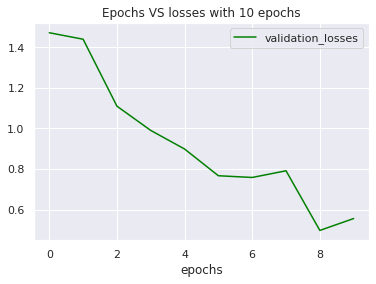

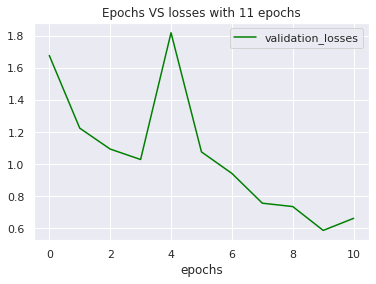

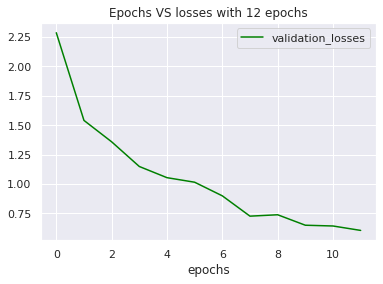

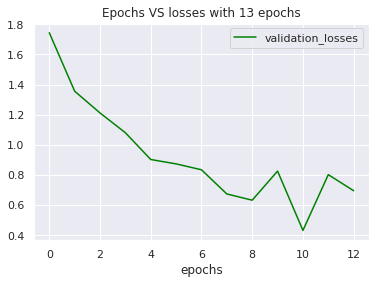

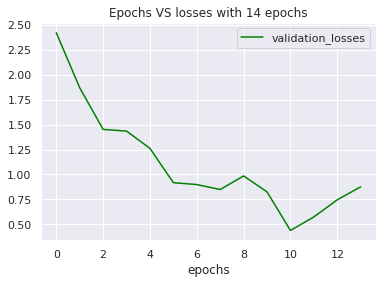

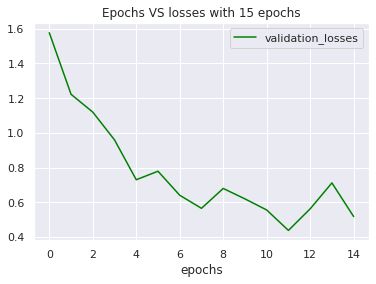

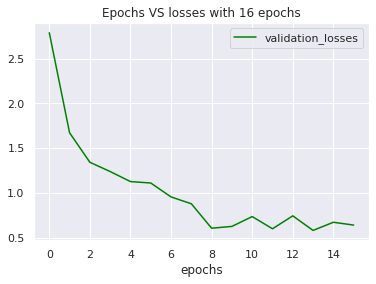

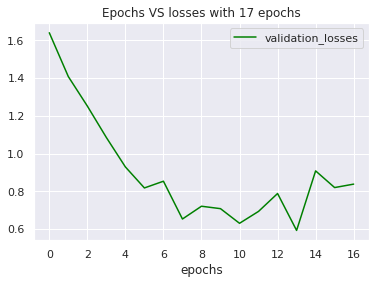

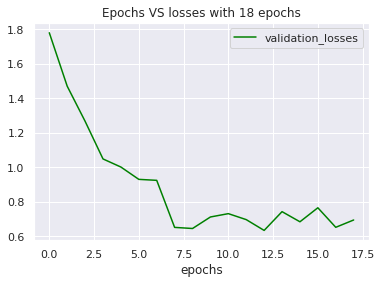

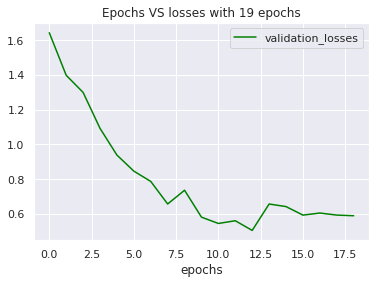

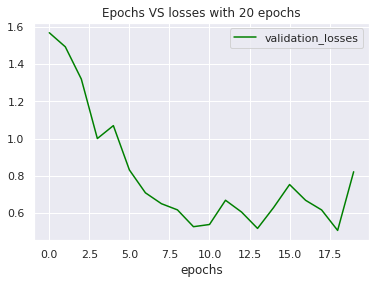

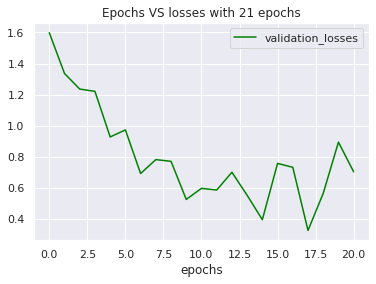

In [ ]:
batch_size = 16
for n_epochs in range(10,22):
  epoch_to_str = str(n_epochs)
  batch_size_to_str = str(batch_size)
  validation_losses_epoch = pd.read_csv(model_path+'mt5_model_'+epoch_to_str+'_'+batch_size_to_str+'.csv')

  # gca stands for 'get current axis'
  ax = plt.gca()
  validation_losses_epoch.plot(kind='line',x='epochs',y='validation_losses', color='green',ax=ax)
  plt.title("Epochs VS losses with "+epoch_to_str+" epochs" )
  plt.show()
  print('\n')

In [ ]:
# test_loss = eval_model(model, test_dataset)
# test_loss

In [ ]:
# validation_losses_epoch


In [ ]:
# gca stands for 'get current axis'


# ax = plt.gca()
# validation_losses_epoch.plot(kind='line',x='epochs',y='validation_losses', color='green',ax=ax)
# plt.title("Epochs VS losses")
# plt.show()

In [ ]:
# Graph the loss

# window_size = 50
# smoothed_losses = []
# for i in range(len(losses)-window_size):
#   smoothed_losses.append(np.mean(losses[i:i+window_size]))

# plt.title("Data translated VS losses")
# plt.plot(smoothed_losses[100:])

## Manual Testing

In [ ]:
test_sentence = test_dataset.iloc[5]['French']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'Fon',
    tokenizer = tokenizer,
    seq_len = model.config.max_length, 
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: Tu racontes ce que tu as vu
Truncated input text: <fo> Tu racontes ce que tu as vu</s><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Nuɖe a mɔ ɖɔ a ɖe ɔ ɖ
A ɖɔ nuɖe a ɖɔ ɔ a ɖe
Nuɖe a mɔ ɖɔ ɔ a ɖe ɔ


In [ ]:
eval_data.loc[3502]['Fon']

'Ye mɛxo tawun wɛ, ye ko nɔ ɖo xwe…'

In [ ]:
 eval_data[130:150]

,Fon,French
3329,Avun slɛ́ gŏ,Les chiens se sont accouplés.
3348,"Kintɔ enɛ ɔ lɛ sɔ si do gudo fɔ a, ayijijɛ yet...","Acculés, leur défaite semblait imminente."
3362,A xɔ nu kpɛɖe à ?,As-tu acheté un peu ?
3378,Un jlo na xɔ nu,Je voudrais acheter.
3436,É d’áfɔ gbĕ,Elle a commis l’adultère.
3495,Sɛ ɖó zan n’í,Il est mort très âgé.
3502,"Ye mɛxo tawun wɛ, ye ko nɔ ɖo xwe…","Ils sont vraiment des adultes, ils sont déjà à..."
3524,"Zàn élɔ́ mɛ́ ɔ́, vì tɔ́n xò sù káká","Cette nuit, son enfant a été très agité."
3538,É zún fan atín ɔ́,Il s’est agrippé à l’arbre.
3570,Ze nyɛvi ɖokpo nu mi,Donne-moi une aiguille.


In [ ]:
# model_1 = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
import torch
model = torch.load('/content/drive/MyDrive/Colab Notebooks/afrikdico/models/mt5_model_19_16.pt')
eval_model(model, eval_data, batch_size=16)

 # Adding vocab tokens savely using the <> to avoid errors if they are already prensent in the tokenzer
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))


Embedding(250102, 512)

In [ ]:
#@title TRANSLATOR MODEL VERSION 1.00
input_text = 'ahan d\xEDng\xE0n' #@param {type:"string"}
output_language = 'French' #@param ["Fon", "French"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


ahan díngàn  ->  du trop de bouger
